This file is a modifcation of pbmc_multiome_tutorial.ipynb

# Tutorial: 10x multiome pbmc


The data consists of *PBMC from a Healthy Donor - Granulocytes Removed Through Cell Sorting (3k)* which is freely available from 10x Genomics (click [here](https://www.10xgenomics.com/resources/datasets/pbmc-from-a-healthy-donor-granulocytes-removed-through-cell-sorting-3-k-1-standard-2-0-0), some personal information needs to be provided before you can gain access to the data). This is a multi-ome dataset.

<div class="alert alert-info">

**Note:**

In this notebook we will only show the minimal steps needed for running the SCENIC+ analysis. For more information on analysing scRNA-seq data and scATAC-seq data we refer the reader to other tutorials (e.g. [Scanpy](https://scanpy-tutorials.readthedocs.io/en/latest/index.html) and [pycisTopic](https://pycistopic.readthedocs.io/en/latest/) in python or [Seurat](https://satijalab.org/seurat/) and [cisTopic](https://github.com/aertslab/cisTopic) or [Signac](https://satijalab.org/signac/) in R).

</div>



## Set-up environment and download data 
We will first create a directory to store the data and results

In [1]:
#supress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
import os
_stderr = sys.stderr                                                         
null = open(os.devnull,'wb')

In [2]:
import os
work_dir = '.'

## scRNA-seq preprocessing using Scanpy
First we preprocess the scRNA-seq side of the mutliome datasets. Most importantly we will use this side of the data to annotate celltypes. 

For this we will make use of [Scanpy](https://scanpy.readthedocs.io/en/stable/). 


<div class="alert alert-info">

**Note:**

You may also use [Seurat](https://satijalab.org/seurat/) (or any other tool in fact) to preprocess your data, however this will require some extra steps to import the data in python.
</div>

<div class="alert alert-info">

**Note:**

Further on in the actual SCENIC+ analysis the raw count matrix will be used.
</div>


In [3]:
import scanpy as sc
#set some figure parameters for nice display inside jupyternotebooks.
%matplotlib inline
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(5, 5), facecolor='white')

#make a directory for to store the processed scRNA-seq data.
if not os.path.exists(os.path.join(work_dir, 'scRNA')):
    os.makedirs(os.path.join(work_dir, 'scRNA'))

Read in the scRNA-seq count matrix into [AnnData](https://anndata.readthedocs.io/en/latest/) object.

In [4]:
adata = sc.read_h5ad(os.path.join(work_dir, 'scenicplus_scRNA.h5ad'))
adata

AnnData object with n_obs × n_vars = 14486 × 17278
    obs: 'sample_id', 'louvain', 'louvain_annot', 'celltype'
    var: 'gene_ids'
    obsm: 'X_pca', 'X_umap'

/usr/local/miniconda3/envs/scenicplus/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


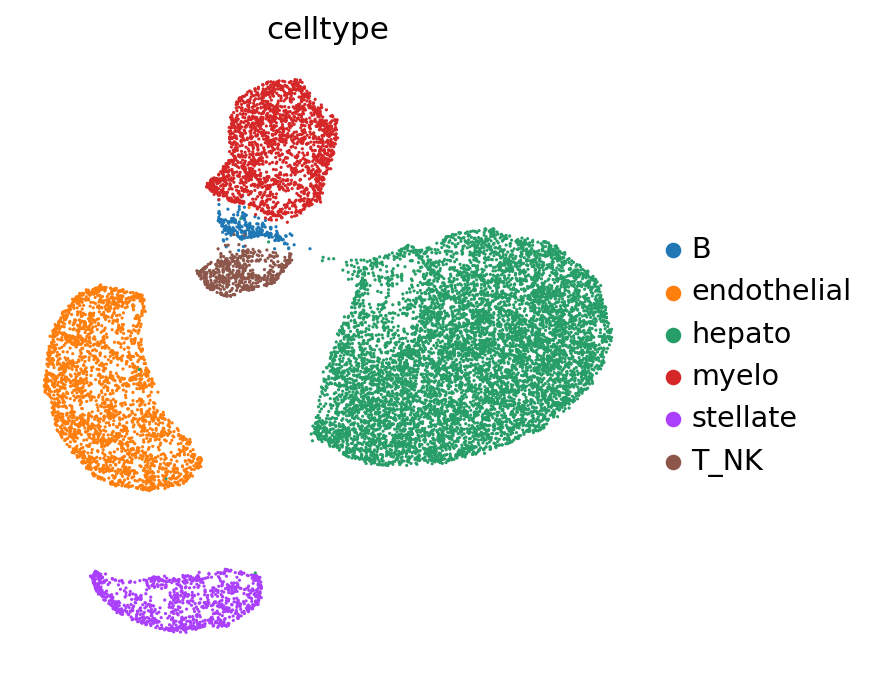

In [6]:
sc.pl.umap(adata, color = 'celltype')

We now have preprocessed the scRNA-seq side of the multiome data.

In particular we have:

1. fitlered the data to only contain high quality cells.
2. annotated cells to cell types.

We also did some preliminary visualization of the data for which we needed to normalize the gene expression counts. Note that SCENIC+ uses the raw gene expression counts (i.e. without normalization and scaling). We have kept this raw data in `adata.raw`.

Now that we have clusters of annotated cells we can continue with preprocessing the scATAC-seq data. There we will use the annotated clusters of cells to generate pseudobulk ATAC-seq profiles per cell type which will be used for peak calling.

## scATAC-seq preprocessing using pycisTopic

Now we will preprocess the scATAC-seq side of the multiome data.

Most importantly we will:

1. generate pseudobulk ATAC-seq profiles per cell type and call peaks
2. merge these peaks into a consensus peak-set
3. do quality control on the scATAC-seq barcodes
4. run topic modeling to find sets of co-accessible regions and to impute chromatin accessibility resolving the issue of drop outs

For this we will use the python package [pycisTopic](https://pycistopic.readthedocs.io/en/latest/). 

<div class="alert alert-info">

**Note:**

pycisTopic can also be used for independent analysis of scATAC-seq data and has many more features which will not be demonstrated here. For more information see the read the docs page of [pycisTopic](https://pycistopic.readthedocs.io/en/latest/)
</div>

In [7]:
import os
work_dir = '.'
import pycisTopic
#set some figure parameters for nice display inside jupyternotebooks.
%matplotlib inline

#make a directory for to store the processed scRNA-seq data.
if not os.path.exists(os.path.join(work_dir, 'scATAC')):
    os.makedirs(os.path.join(work_dir, 'scATAC'))
tmp_dir = '/tmp'

In [9]:
# Create cisTopic object
from pycisTopic.cistopic_class import *
import scipy as sp

count_matrix = sp.io.mmread(
    "scenicplus_PeakMatrix.mtx")
count_matrix = sparse.coo_matrix.tocsr(count_matrix)
cell_names = pd.read_csv(
    "scenicplus_PeakMatrix.col.txt", header=None)[0]
region_names = pd.read_csv(
    "scenicplus_PeakMatrix.row.txt", header=None)[0]
cistopic_obj = create_cistopic_object(
    fragment_matrix=count_matrix,
    cell_names=cell_names,
    region_names=region_names)
del count_matrix, region_names, cell_names
print(cistopic_obj)

2023-04-25 17:26:42,917 cisTopic     INFO     Creating CistopicObject
2023-04-25 17:26:48,717 cisTopic     INFO     Done!
CistopicObject from project cisTopic with n_cells × n_regions = 14486 × 599035


In [19]:
import scanpy as sc
adata = sc.read_h5ad(os.path.join(work_dir, 'scenicplus_scRNA.h5ad'))
cell_data = adata.obs
cell_data['sample_id'] = cell_data['sample_id'].astype(str)
cell_data['celltype'] = cell_data['celltype'].astype(str) # set data type of the celltype column to str, otherwise the export_pseudobulk function will complain.
del(adata)

In [22]:
cistopic_obj.add_cell_data(cell_data)

Columns ['sample_id'] will be overwritten


In [24]:
pickle.dump(cistopic_obj,
            open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'wb'))

Run topic modeling. The purpose of this is twofold:

1. To find sets of co-accessible regions (topics), this will be used downstream as candidate enhancers (together with Differentially Accessible Regions (DARs)).
2. To impute dropouts. 

<div class="alert alert-info">

**Note:**

scATAC-seq data is *very* sparse. This is because of the nature of the technique. It profiles chromatin accessibility in single cells and each cell only has two copies (two alleles) of each genomic region, also the genome is realtively large (so the number of regions which can be measured is large). For this reason drop outs are a *real* problem, the chance of measuring a specific genomic region (out of *many* potential regions) which only has two copies per cell is relatively small. Compare this to scRNA-seq analysis, here the number of genes which can be measure is relatively small (compared to the number of genomic regions) and each cell has potentially hundres of copies of each transcript. To account for drop outs in the scATAC-seq assay imputation techniques are often used, in this case we make use of topic modeling, making use of the fact that the data often contains cells which are quite similar to each other but might have slightly different features measured. 
</div>


Before running the topic modeling we are not sure what the best number of topics will be to explain the data. Analog to PCA where you also often don't know before hand what the best number of principle components is. For this reason we will generate models with increasing numbers of topics and after the fact choose the model with the optimal amount of topics. For demonstration purposes we will only try a few amount of models, you might want to explore a larger number of topics.

<div class="alert alert-warning">

**Warning:**

Topic modeling can be computationaly intense!
</div>

In [13]:
import pickle
from pycisTopic.cistopic_class import *
models=run_cgs_models(cistopic_obj,
                    n_topics=[2,4,10,16,32,48],
                    n_cpu=48,
                    n_iter=500,
                    random_state=555,
                    alpha=50,
                    alpha_by_topic=True,
                    eta=0.1,
                    eta_by_topic=False,
                    save_path=None,
                    _temp_dir = os.path.join(tmp_dir + '/ray_spill'))

2023-04-25 17:28:35,378	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 


(run_cgs_model pid=3865173) 2023-04-25 17:28:38,097 cisTopic     INFO     Running model with 2 topics
(run_cgs_model pid=3865179) 2023-04-25 17:28:38,420 cisTopic     INFO     Running model with 4 topics
(run_cgs_model pid=3865161) 2023-04-25 17:28:38,862 cisTopic     INFO     Running model with 10 topics
(run_cgs_model pid=3865154) 2023-04-25 17:28:39,288 cisTopic     INFO     Running model with 16 topics
(run_cgs_model pid=3865140) 2023-04-25 17:28:39,687 cisTopic     INFO     Running model with 32 topics
(run_cgs_model pid=3865142) 2023-04-25 17:28:40,114 cisTopic     INFO     Running model with 48 topics
(run_cgs_model pid=3865173) 2023-04-25 18:42:06,679 cisTopic     INFO     Model with 2 topics done!
(run_cgs_model pid=3865179) 2023-04-25 19:25:22,858 cisTopic     INFO     Model with 4 topics done!
(run_cgs_model pid=3865161) 2023-04-25 21:41:15,132 cisTopic     INFO     Model with 10 topics done!
(run_cgs_model pid=3865154) 2023-04-25 23:35:17,512 cisTopic     INFO     Model wit

Save results

In [14]:
if not os.path.exists(os.path.join(work_dir, 'scATAC/models')):
    os.makedirs(os.path.join(work_dir, 'scATAC/models'))

pickle.dump(models,
            open(os.path.join(work_dir, 'scATAC/models/models_500_iter_LDA.pkl'), 'wb'))

Analyze models.

We will make use of four quality metrics to select the model with the optimal amount of topics:
1. [Arun *et al.* 2010](http://link.springer.com/10.1007/978-3-642-13657-3_43)
2. [Cao & Juan *et al.* 2009](https://linkinghub.elsevier.com/retrieve/pii/S092523120800372X)
3. [Mimno *et al.* 2011](http://dirichlet.net/pdf/mimno11optimizing.pdf)
4. Log likelihood

For more information on these metrics see publications (linked above) and the [read the docs](https://pycistopic.readthedocs.io/en/latest/) page of pycisTopic.

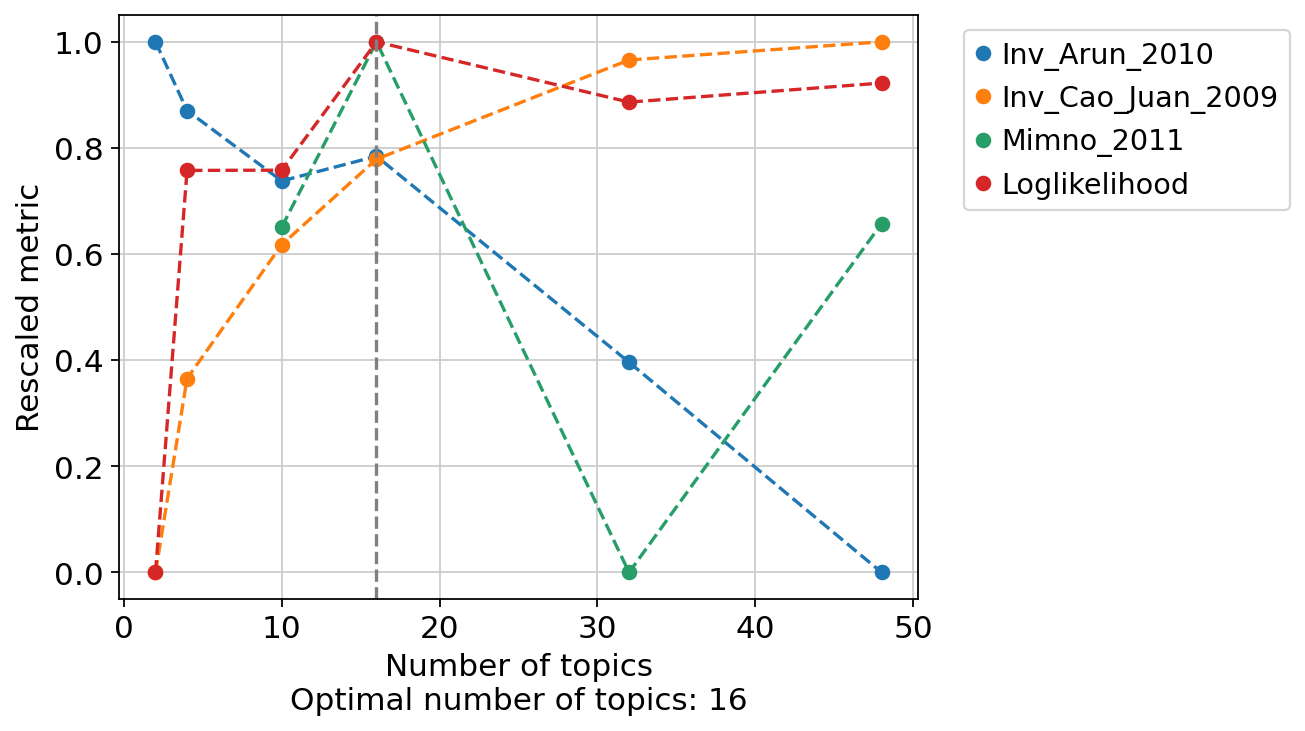

In [9]:
import pickle
models = pickle.load(open(os.path.join(work_dir, 'scATAC/models/models_500_iter_LDA.pkl'), 'rb'))
cistopic_obj = pickle.load(open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'rb'))
from pycisTopic.lda_models import *
model = evaluate_models(models,
                       select_model=16, 
                       return_model=True, 
                       metrics=['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
                       plot_metrics=False)

The metrics seem to stabelise with a model using 16 topics, so let's choose that model. 

In [17]:
cistopic_obj.add_LDA_model(model)
pickle.dump(cistopic_obj,
            open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'wb'))

### Visualization

We can use the cell-topic probabilities to generate dimensionality reductions.

2023-04-27 13:39:43,553 cisTopic     INFO     Running UMAP


/usr/local/miniconda3/envs/scenicplus/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10002. The TBB threading layer is disabled.
  warnings.warn(problem)


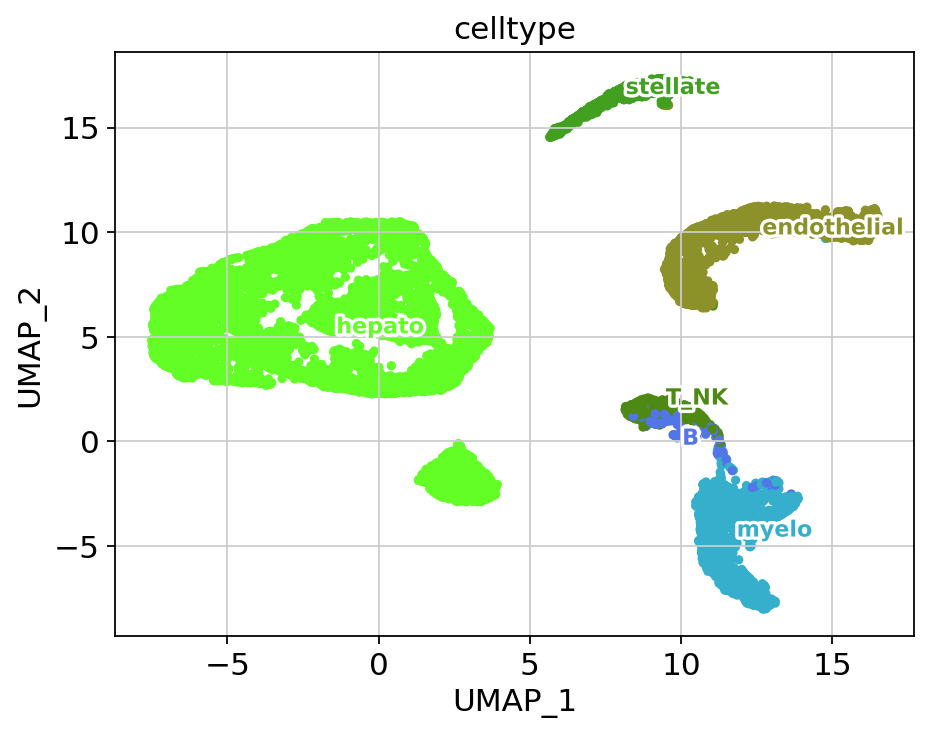

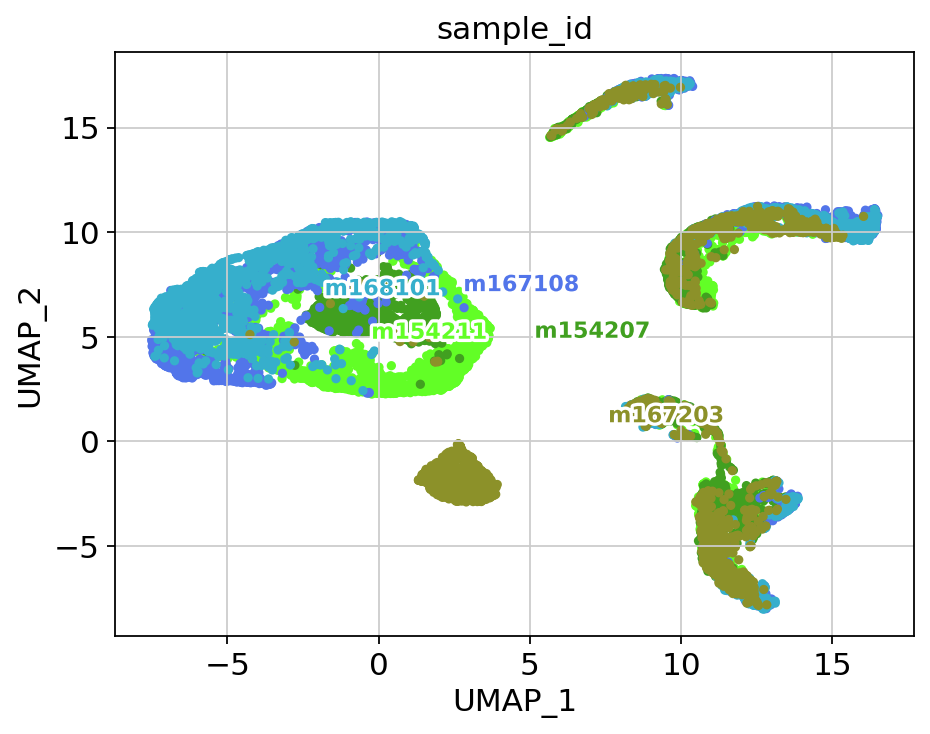

In [10]:
from pycisTopic.clust_vis import *
run_umap(cistopic_obj, target  = 'cell', scale=True)
plot_metadata(cistopic_obj, reduction_name = 'UMAP', variables = ['celltype'])
plot_metadata(cistopic_obj, reduction_name = 'UMAP', variables = ['sample_id'])

We can also plot the cell-topic probabilities on the UMAP, to visualize their cell type specifiticy.

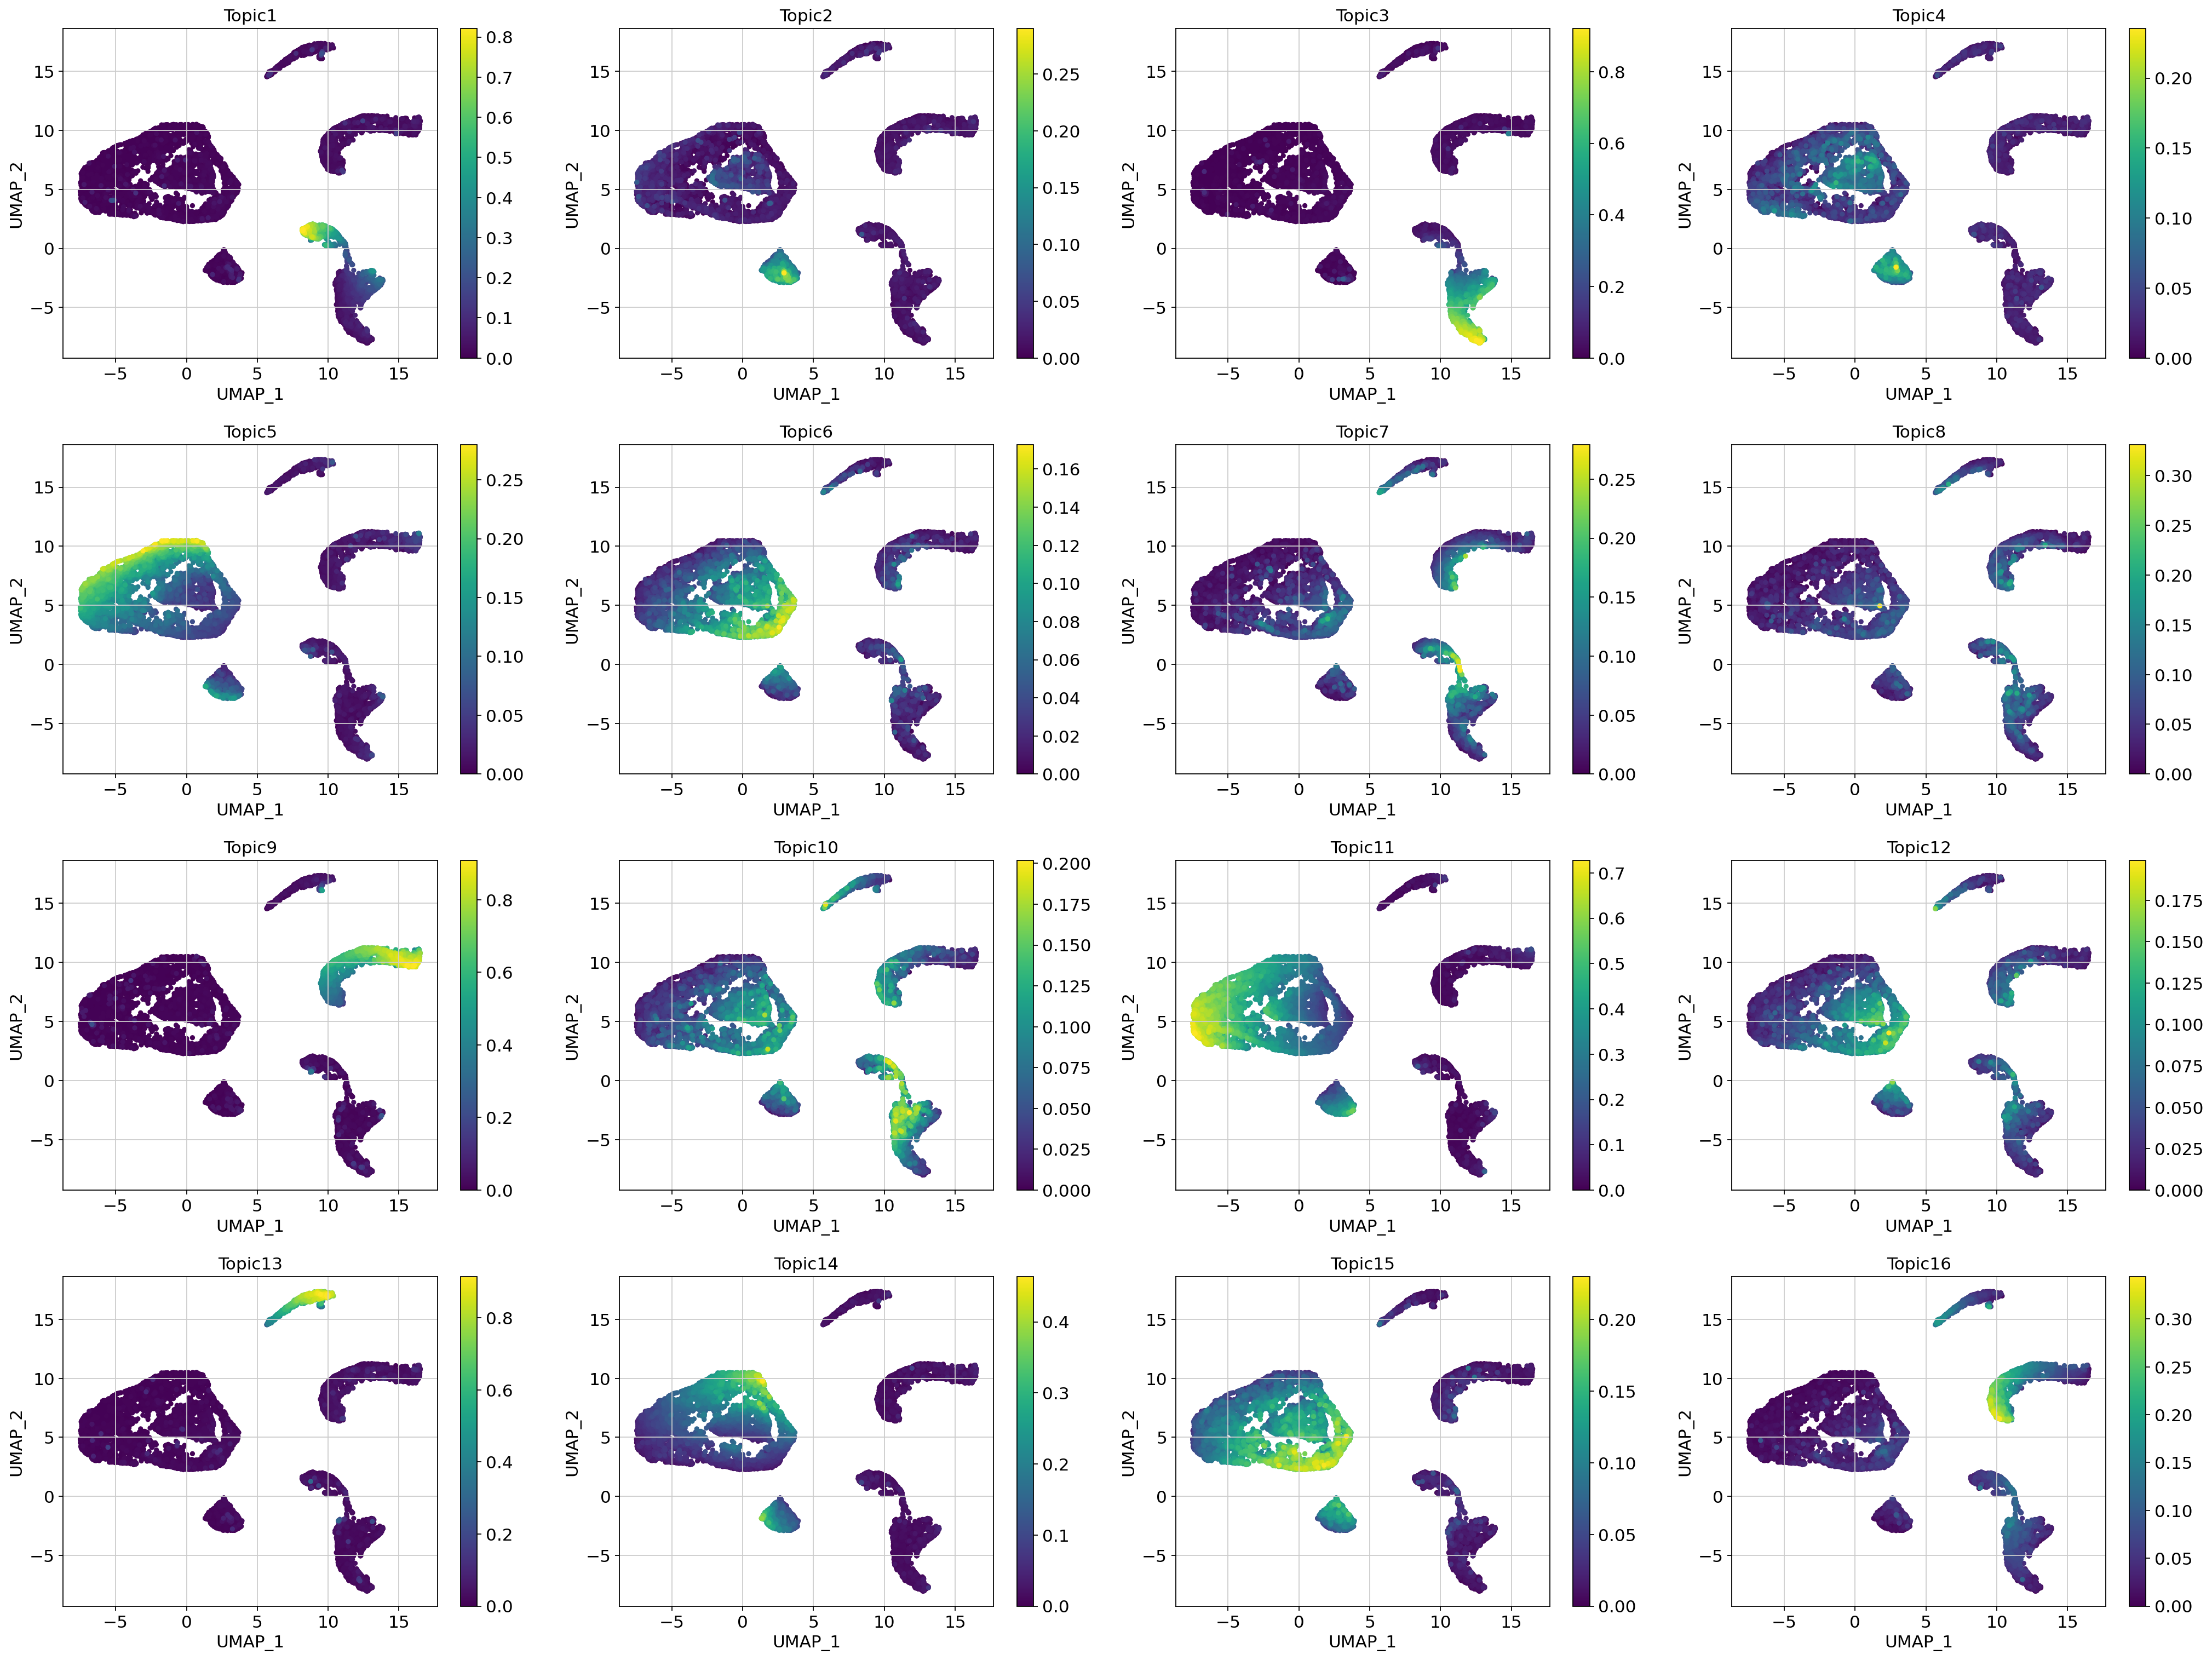

In [11]:
plot_topic(cistopic_obj, reduction_name = 'UMAP', num_columns = 4)

For further analysis see the [pycisTopic read the docs page](https://pycistopic.readthedocs.io/en/latest/)

### Inferring candidate enhancer regions

Next we will infer candidate enhancer regions by:

1. binarization of region-topic probabilites.
2. calculation differentially accessibile regions (DARs) per cell type.

These regions will be used as input for the next step, [pycistarget](https://pycistarget.readthedocs.io/en/latest/), in which we will look which motifs are enriched in these regions.

First we will binarize the topics using the [otsu](http://ieeexplore.ieee.org/document/4310076/) method and by taking the top 3k regions per topic.

In [12]:
from pycisTopic.topic_binarization import *
region_bin_topics_otsu = binarize_topics(cistopic_obj, method='otsu')
region_bin_topics_top3k = binarize_topics(cistopic_obj, method='ntop', ntop = 3000)

<Figure size 512x384 with 0 Axes>

<Figure size 512x384 with 0 Axes>

Next we will calculate DARs per cell type

In [13]:
from pycisTopic.diff_features import *
imputed_acc_obj = impute_accessibility(cistopic_obj, selected_cells=None, selected_regions=None, scale_factor=10**6)
normalized_imputed_acc_obj = normalize_scores(imputed_acc_obj, scale_factor=10**4)
variable_regions = find_highly_variable_features(normalized_imputed_acc_obj, plot = False)
markers_dict = find_diff_features(cistopic_obj, imputed_acc_obj, variable='celltype', var_features=variable_regions, split_pattern = '-')

2023-04-27 13:41:12,647 cisTopic     INFO     Imputing drop-outs
2023-04-27 13:41:30,229 cisTopic     INFO     Scaling
2023-04-27 13:41:44,075 cisTopic     INFO     Keep non zero rows
2023-04-27 13:42:01,845 cisTopic     INFO     Imputed accessibility sparsity: 0.6330396495685439
2023-04-27 13:42:01,846 cisTopic     INFO     Create CistopicImputedFeatures object
2023-04-27 13:42:01,846 cisTopic     INFO     Done!
2023-04-27 13:42:01,847 cisTopic     INFO     Normalizing imputed data
2023-04-27 13:43:04,348 cisTopic     INFO     Done!
2023-04-27 13:43:04,350 cisTopic     INFO     Calculating mean
2023-04-27 13:43:11,099 cisTopic     INFO     Calculating variance
2023-04-27 13:43:51,611 cisTopic     INFO     Done!
2023-04-27 13:43:54,886 cisTopic     INFO     Formatting data for B
2023-04-27 13:44:01,732 cisTopic     INFO     Computing p-value for B
2023-04-27 13:45:17,429 cisTopic     INFO     Computing log2FC for B
2023-04-27 13:45:19,724 cisTopic     INFO     B done!
2023-04-27 13:45:

<Figure size 400x400 with 0 Axes>

Save results

In [34]:
if not os.path.exists(os.path.join(work_dir, 'scATAC/candidate_enhancers')):
    os.makedirs(os.path.join(work_dir, 'scATAC/candidate_enhancers'))
import pickle
pickle.dump(region_bin_topics_otsu, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/region_bin_topics_otsu.pkl'), 'wb'))
pickle.dump(region_bin_topics_top3k, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/region_bin_topics_top3k.pkl'), 'wb'))
pickle.dump(markers_dict, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/markers_dict.pkl'), 'wb'))

We now completed all the mininal scATAC-seq preprocessing steps. 

In particular we:

1. generated a set of consensus peaks
2. performed quality control steps, only keeping cell barcods which passed QC metrics in both the scRNA-seq and scATAC-seq assay
3. performed topic modeling
4. inferred candidate enhancer regions by binarizing the region-topic probabilities and DARs per cell type

In the next step we will perform motif enrichment analysis on these candidate enhancer regions using the python package, [pycistarget](phttps://pycistarget.readthedocs.io/en/latest/). For this a precomputed motif-score database is needed. A sample specific database can be generated by scoring the consensus peaks with motifs or a general pre-scored database can be used as well.

## Motif enrichment analysis using pycistarget

After having identified candidate enhancer regions we will use [pycistarget](https://pycistarget.readthedocs.io/en/latest/) to find which motifs are enriched in these regions. 

### Cistarget databases

In order to run pycistarget one needs a precomputed database containing motif scores for genomic regions.

You can choose to compute this database yourself by scoring the consensus peaks generated in the scATAC-seq analysis using a set of motifs. The advantage of creating a sample specific database is that you can potentially pick up more target regions, given that only regions included/overlappig with regions in the cistarget database will be used for the SCENIC+ analysis. For more information checkout the [create_cisTarget_databases repo on github](https://github.com/aertslab/create_cisTarget_databases). 

We also provide several precomputed databases containing regions covering many experimentally defined candidate cis-regulatory elements. These databases are available on: [https://resources.aertslab.org/cistarget/](https://resources.aertslab.org/cistarget/).

For this analysis we will use a precomputed database using [screen regions](https://screen.encodeproject.org/).

Next to a precomputed motif database we also need a motif-to-tf annotation database. This is also available on [https://resources.aertslab.org/cistarget/](https://resources.aertslab.org/cistarget/).

Load candidate enhancer regions identified in previous step.

In [14]:
import pickle
region_bin_topics_otsu = pickle.load(open(os.path.join(work_dir, 'scATAC/candidate_enhancers/region_bin_topics_otsu.pkl'), 'rb'))
region_bin_topics_top3k = pickle.load(open(os.path.join(work_dir, 'scATAC/candidate_enhancers/region_bin_topics_top3k.pkl'), 'rb'))
markers_dict = pickle.load(open(os.path.join(work_dir, 'scATAC/candidate_enhancers/markers_dict.pkl'), 'rb'))

Convert to dictionary of pyranges objects.

In [15]:
import pyranges as pr
from pycistarget.utils import region_names_to_coordinates
region_sets = {}
region_sets['topics_otsu'] = {}
region_sets['topics_top_3'] = {}
region_sets['DARs'] = {}
for topic in region_bin_topics_otsu.keys():
    regions = region_bin_topics_otsu[topic].index[region_bin_topics_otsu[topic].index.str.startswith('chr')] #only keep regions on known chromosomes
    region_sets['topics_otsu'][topic] = pr.PyRanges(region_names_to_coordinates(regions))
for topic in region_bin_topics_top3k.keys():
    regions = region_bin_topics_top3k[topic].index[region_bin_topics_top3k[topic].index.str.startswith('chr')] #only keep regions on known chromosomes
    region_sets['topics_top_3'][topic] = pr.PyRanges(region_names_to_coordinates(regions))
for DAR in markers_dict.keys():
    regions = markers_dict[DAR].index[markers_dict[DAR].index.str.startswith('chr')] #only keep regions on known chromosomes
    region_sets['DARs'][DAR] = pr.PyRanges(region_names_to_coordinates(regions))

In [16]:
for key in region_sets.keys():
    print(f'{key}: {region_sets[key].keys()}')

topics_otsu: dict_keys(['Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5', 'Topic6', 'Topic7', 'Topic8', 'Topic9', 'Topic10', 'Topic11', 'Topic12', 'Topic13', 'Topic14', 'Topic15', 'Topic16'])
topics_top_3: dict_keys(['Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5', 'Topic6', 'Topic7', 'Topic8', 'Topic9', 'Topic10', 'Topic11', 'Topic12', 'Topic13', 'Topic14', 'Topic15', 'Topic16'])
DARs: dict_keys(['B', 'T_NK', 'endothelial', 'hepato', 'myelo', 'stellate'])


Define rankings, score and motif annotation database.

The ranking database is used for running the cistarget analysis and the scores database is used for running the DEM analysis. For more information see [the pycistarget read the docs page](https://pycistarget.readthedocs.io/en/latest/)


In [17]:
db_fpath = "/home/fumi/human/rat_singlecell_liver/scenicplus/create_cisTarget_databases"
motif_annot_fpath = "/home/fumi/human/rat_singlecell_liver/scenicplus/create_cisTarget_databases/v10nr_clust_public/snapshots"

In [18]:
rankings_db = os.path.join(db_fpath, 'scenicplus_PeakMatrix_db.regions_vs_motifs.rankings.feather')
scores_db =  os.path.join(db_fpath, 'scenicplus_PeakMatrix_db.regions_vs_motifs.scores.feather')
motif_annotation = os.path.join(motif_annot_fpath, 'motifs-v10-nr.mgi-m0.00001-o0.0.tbl')

Next we will run pycistarget using the `run_pycistarget` wrapper function.

This function will run cistarget based and DEM based motif enrichment analysis with or without promoter regions.


In [19]:
if not os.path.exists(os.path.join(work_dir, 'motifs')):
    os.makedirs(os.path.join(work_dir, 'motifs'))

In [1]:
import scenicplus

In [20]:
from scenicplus.wrappers.run_pycistarget import run_pycistarget
run_pycistarget(
    region_sets = region_sets,
    species = 'mus_musculus',
    save_path = os.path.join(work_dir, 'motifs'),
    ctx_db_path = rankings_db,
    dem_db_path = scores_db,
    path_to_motif_annotations = motif_annotation,
    run_without_promoters = True,
    n_cpu = 36,
    _temp_dir = os.path.join(tmp_dir, 'ray_spill'),
    annotation_version = 'v10nr_clust',
    )

2023-04-27 13:54:07,183 pycisTarget_wrapper INFO     ./motifs folder already exists.
2023-04-27 13:55:06,405 pycisTarget_wrapper INFO     Loading cisTarget database for topics_otsu
2023-04-27 13:55:06,406 cisTarget    INFO     Reading cisTarget database


/usr/local/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pybiomart/dataset.py:269: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  result = pd.read_csv(StringIO(response.text), sep='\t')


2023-04-27 13:59:01,298 pycisTarget_wrapper INFO     Running cisTarget for topics_otsu


2023-04-27 13:59:03,976	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


(ctx_internal_ray pid=4026350) 2023-04-27 13:59:07,996 cisTarget    INFO     Running cisTarget for Topic1 which has 12050 regions
(ctx_internal_ray pid=4026322) 2023-04-27 13:59:14,308 cisTarget    INFO     Running cisTarget for Topic4 which has 21569 regions [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(ctx_internal_ray pid=4026350) 2023-04-27 13:59:19,013 cisTarget    INFO     Annotating motifs for Topic1
(ctx_internal_ray pid=4026338) 2023-04-27 13:59:18,467 cisTarget    INFO     Running cisTarget for Topic6 which has 31499 regions [repeated 2x across cluster]
(ctx_internal_ray pid=4026332) 2023-04-27 13:59:24,563 cisTarget    INFO     Getting cistromes for Topic2
(ctx_internal_ray pid=4026332) 2023-04-27 13:59:24,563 cisTarget    INFO     Getting cistromes for Topic2
(ctx_internal_ray pid=4026335) 2023-04-

2023-04-27 14:01:24,302	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


(ctx_internal_ray pid=4031055) 2023-04-27 14:01:28,621 cisTarget    INFO     Running cisTarget for Topic1 which has 11871 regions
(ctx_internal_ray pid=4031073) 2023-04-27 14:01:35,814 cisTarget    INFO     Running cisTarget for Topic4 which has 21205 regions [repeated 3x across cluster]
(ctx_internal_ray pid=4031055) 2023-04-27 14:01:40,114 cisTarget    INFO     Annotating motifs for Topic1
(ctx_internal_ray pid=4031074) 2023-04-27 14:01:40,884 cisTarget    INFO     Annotating motifs for Topic2
(ctx_internal_ray pid=4031062) 2023-04-27 14:01:40,956 cisTarget    INFO     Running cisTarget for Topic6 which has 30967 regions
(ctx_internal_ray pid=4031060) 2023-04-27 14:01:43,413 cisTarget    INFO     Getting cistromes for Topic2
(ctx_internal_ray pid=4031060) 2023-04-27 14:01:45,155 cisTarget    INFO     Running cisTarget for Topic8 which has 47587 regions
(ctx_internal_ray pid=4031070) 2023-04-27 14:01:48,091 cisTarget    INFO     Annotating motifs for Topic3
(ctx_internal_ray pid=40310

2023-04-27 14:05:56,013	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


(DEM_internal_ray pid=4035678) 2023-04-27 14:06:06,220 DEM          INFO     Computing DEM for Topic1
(DEM_internal_ray pid=4035679) 2023-04-27 14:06:13,492 DEM          INFO     Computing DEM for Topic7 [repeated 2x across cluster]
(DEM_internal_ray pid=4035673) 2023-04-27 14:06:18,947 DEM          INFO     Computing DEM for Topic4 [repeated 2x across cluster]
(DEM_internal_ray pid=4035677) 2023-04-27 14:06:19,800 DEM          INFO     Computing DEM for Topic5
2023-04-27 14:11:25,153 DEM          INFO     Forming cistromes
2023-04-27 14:11:28,865 DEM          INFO     Done!
2023-04-27 14:11:47,128 pycisTarget_wrapper INFO     Created folder : ./motifs/DEM_topics_otsu_All
2023-04-27 14:11:47,537 pycisTarget_wrapper INFO     Running DEM without promoters for topics_otsu
2023-04-27 14:12:10,696 DEM          INFO     Creating contrast groups


2023-04-27 14:12:19,737	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


(DEM_internal_ray pid=4038595) 2023-04-27 14:12:29,372 DEM          INFO     Computing DEM for Topic1
(DEM_internal_ray pid=4038593) 2023-04-27 14:12:37,400 DEM          INFO     Computing DEM for Topic7 [repeated 2x across cluster]
(DEM_internal_ray pid=4038591) 2023-04-27 14:12:41,555 DEM          INFO     Computing DEM for Topic5 [repeated 3x across cluster]
2023-04-27 14:17:13,201 DEM          INFO     Forming cistromes
2023-04-27 14:17:16,996 DEM          INFO     Done!
2023-04-27 14:17:35,439 pycisTarget_wrapper INFO     Created folder : ./motifs/DEM_topics_otsu_No_promoters
2023-04-27 14:17:35,839 pycisTarget_wrapper INFO     Loading cisTarget database for topics_top_3
2023-04-27 14:17:35,839 cisTarget    INFO     Reading cisTarget database
2023-04-27 14:19:25,831 pycisTarget_wrapper INFO     Running cisTarget for topics_top_3


2023-04-27 14:19:28,767	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


(ctx_internal_ray pid=4041732) 2023-04-27 14:19:30,595 cisTarget    INFO     Running cisTarget for Topic1 which has 3000 regions
(ctx_internal_ray pid=4041719) 2023-04-27 14:19:38,383 cisTarget    INFO     Annotating motifs for Topic2
(ctx_internal_ray pid=4041709) 2023-04-27 14:19:34,125 cisTarget    INFO     Running cisTarget for Topic16 which has 3000 regions [repeated 15x across cluster]
(ctx_internal_ray pid=4041719) 2023-04-27 14:19:40,070 cisTarget    INFO     Getting cistromes for Topic2
(ctx_internal_ray pid=4041712) 2023-04-27 14:19:42,635 cisTarget    INFO     Annotating motifs for Topic13 [repeated 15x across cluster]
(ctx_internal_ray pid=4041712) 2023-04-27 14:19:44,487 cisTarget    INFO     Getting cistromes for Topic13 [repeated 15x across cluster]
2023-04-27 14:19:49,538 cisTarget    INFO     Done!
2023-04-27 14:19:49,540 pycisTarget_wrapper INFO     Created folder : ./motifs/CTX_topics_top_3_All
2023-04-27 14:19:49,704 pycisTarget_wrapper INFO     Running cisTarget wi

2023-04-27 14:19:57,264	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


(ctx_internal_ray pid=4045477) 2023-04-27 14:19:58,838 cisTarget    INFO     Running cisTarget for Topic1 which has 2953 regions
(ctx_internal_ray pid=4045477) 2023-04-27 14:20:06,960 cisTarget    INFO     Annotating motifs for Topic1
(ctx_internal_ray pid=4045468) 2023-04-27 14:20:02,609 cisTarget    INFO     Running cisTarget for Topic16 which has 2949 regions [repeated 15x across cluster]
(ctx_internal_ray pid=4045476) 2023-04-27 14:20:09,237 cisTarget    INFO     Getting cistromes for Topic2
(ctx_internal_ray pid=4045462) 2023-04-27 14:20:10,531 cisTarget    INFO     Annotating motifs for Topic14 [repeated 15x across cluster]
(ctx_internal_ray pid=4045462) 2023-04-27 14:20:12,301 cisTarget    INFO     Getting cistromes for Topic14 [repeated 15x across cluster]
2023-04-27 14:20:17,343 cisTarget    INFO     Done!
2023-04-27 14:20:17,344 pycisTarget_wrapper INFO     Created folder:./motifs/CTX_topics_top_3_No_promoters
2023-04-27 14:20:17,509 pycisTarget_wrapper INFO     Running DEM f

2023-04-27 14:20:59,057	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


(DEM_internal_ray pid=4049222) 2023-04-27 14:21:01,946 DEM          INFO     Computing DEM for Topic1
(DEM_internal_ray pid=4049219) 2023-04-27 14:21:05,353 DEM          INFO     Computing DEM for Topic16 [repeated 15x across cluster]
2023-04-27 14:21:50,266 DEM          INFO     Forming cistromes
2023-04-27 14:21:53,202 DEM          INFO     Done!
2023-04-27 14:21:55,558 pycisTarget_wrapper INFO     Created folder : ./motifs/DEM_topics_top_3_All
2023-04-27 14:21:55,967 pycisTarget_wrapper INFO     Running DEM without promoters for topics_top_3
2023-04-27 14:22:01,902 DEM          INFO     Creating contrast groups


2023-04-27 14:22:05,496	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


(DEM_internal_ray pid=4051390) 2023-04-27 14:22:08,477 DEM          INFO     Computing DEM for Topic1
(DEM_internal_ray pid=4051395) 2023-04-27 14:22:11,899 DEM          INFO     Computing DEM for Topic16 [repeated 15x across cluster]
2023-04-27 14:22:55,780 DEM          INFO     Forming cistromes
2023-04-27 14:22:58,496 DEM          INFO     Done!
2023-04-27 14:23:00,846 pycisTarget_wrapper INFO     Created folder : ./motifs/DEM_topics_top_3_No_promoters
2023-04-27 14:23:01,229 pycisTarget_wrapper INFO     Loading cisTarget database for DARs
2023-04-27 14:23:01,230 cisTarget    INFO     Reading cisTarget database
2023-04-27 14:25:20,114 pycisTarget_wrapper INFO     Running cisTarget for DARs


2023-04-27 14:25:23,083	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


(ctx_internal_ray pid=4054164) 2023-04-27 14:25:25,213 cisTarget    INFO     Running cisTarget for B which has 14704 regions
(ctx_internal_ray pid=4054162) 2023-04-27 14:25:25,562 cisTarget    INFO     Running cisTarget for T_NK which has 14003 regions
(ctx_internal_ray pid=4054156) 2023-04-27 14:25:26,142 cisTarget    INFO     Running cisTarget for endothelial which has 27529 regions
(ctx_internal_ray pid=4054161) 2023-04-27 14:25:26,699 cisTarget    INFO     Running cisTarget for hepato which has 38209 regions
(ctx_internal_ray pid=4054167) 2023-04-27 14:25:27,245 cisTarget    INFO     Running cisTarget for myelo which has 24114 regions
(ctx_internal_ray pid=4054171) 2023-04-27 14:25:27,785 cisTarget    INFO     Running cisTarget for stellate which has 16817 regions
(ctx_internal_ray pid=4054164) 2023-04-27 14:25:35,981 cisTarget    INFO     Annotating motifs for B
(ctx_internal_ray pid=4054162) 2023-04-27 14:25:36,555 cisTarget    INFO     Annotating motifs for T_NK
(ctx_internal_ra

2023-04-27 14:26:04,172	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


(ctx_internal_ray pid=4057804) 2023-04-27 14:26:06,063 cisTarget    INFO     Running cisTarget for B which has 14463 regions
(ctx_internal_ray pid=4057790) 2023-04-27 14:26:06,578 cisTarget    INFO     Running cisTarget for T_NK which has 13774 regions
(ctx_internal_ray pid=4057787) 2023-04-27 14:26:07,132 cisTarget    INFO     Running cisTarget for endothelial which has 27049 regions
(ctx_internal_ray pid=4057795) 2023-04-27 14:26:07,699 cisTarget    INFO     Running cisTarget for hepato which has 37518 regions
(ctx_internal_ray pid=4057781) 2023-04-27 14:26:08,220 cisTarget    INFO     Running cisTarget for myelo which has 23713 regions
(ctx_internal_ray pid=4057793) 2023-04-27 14:26:08,711 cisTarget    INFO     Running cisTarget for stellate which has 16535 regions
(ctx_internal_ray pid=4057804) 2023-04-27 14:26:16,438 cisTarget    INFO     Annotating motifs for B
(ctx_internal_ray pid=4057790) 2023-04-27 14:26:17,035 cisTarget    INFO     Annotating motifs for T_NK
(ctx_internal_ra

2023-04-27 14:27:21,586	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


(DEM_internal_ray pid=4061425) 2023-04-27 14:27:30,745 DEM          INFO     Computing DEM for B
(DEM_internal_ray pid=4061422) 2023-04-27 14:27:31,148 DEM          INFO     Computing DEM for T_NK
(DEM_internal_ray pid=4061423) 2023-04-27 14:27:34,446 DEM          INFO     Computing DEM for stellate
(DEM_internal_ray pid=4061424) 2023-04-27 14:27:36,405 DEM          INFO     Computing DEM for myelo
(DEM_internal_ray pid=4061427) 2023-04-27 14:27:39,258 DEM          INFO     Computing DEM for endothelial
(DEM_internal_ray pid=4061426) 2023-04-27 14:27:44,363 DEM          INFO     Computing DEM for hepato
2023-04-27 14:29:05,398 DEM          INFO     Forming cistromes
2023-04-27 14:29:06,892 DEM          INFO     Done!
2023-04-27 14:29:08,819 pycisTarget_wrapper INFO     Created folder : ./motifs/DEM_DARs_All
2023-04-27 14:29:08,896 pycisTarget_wrapper INFO     Running DEM without promoters for DARs
2023-04-27 14:29:14,964 DEM          INFO     Creating contrast groups


2023-04-27 14:29:18,708	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


(DEM_internal_ray pid=4062771) 2023-04-27 14:29:27,211 DEM          INFO     Computing DEM for T_NK
(DEM_internal_ray pid=4062768) 2023-04-27 14:29:27,808 DEM          INFO     Computing DEM for B
(DEM_internal_ray pid=4062769) 2023-04-27 14:29:32,182 DEM          INFO     Computing DEM for stellate
(DEM_internal_ray pid=4062767) 2023-04-27 14:29:35,718 DEM          INFO     Computing DEM for endothelial
(DEM_internal_ray pid=4062770) 2023-04-27 14:29:35,818 DEM          INFO     Computing DEM for myelo
(DEM_internal_ray pid=4062766) 2023-04-27 14:29:38,867 DEM          INFO     Computing DEM for hepato
2023-04-27 14:30:57,333 DEM          INFO     Forming cistromes
2023-04-27 14:30:58,585 DEM          INFO     Done!
2023-04-27 14:31:00,532 pycisTarget_wrapper INFO     Created folder : ./motifs/DEM_DARs_No_promoters
2023-04-27 14:31:00,603 pycisTarget_wrapper INFO     Saving object
2023-04-27 14:47:31,426 pycisTarget_wrapper INFO     Finished! Took 53.404044246673585 minutes


Let's explore some of the results. Below we show the motifs found for topic 8 (specific to B-cells) using DEM.

In [21]:
import dill
menr = dill.load(open(os.path.join(work_dir, 'motifs/menr.pkl'), 'rb'))

In [25]:
menr['DEM_topics_otsu_All'].DEM_results('Topic2')

We now have completed all the steps necessary for starting the SCENIC+ analysis 😅.

In particalular, we have

1. preprocessed the scRNA-seq side of the data, selecting high quality cells and annotation these cells.
2. preprocessed the scATAC-seq side of the data, selecting high quality cells, performing topic modeling and identifying candidate enhacer regions.
3. looked for enriched motifs in candidate enhancer regions.

In the next section we will combine all these analysis and run SCENIC+


## inferring enhancer-driven Gene Regulatory Networks (eGRNs) using SCENIC+

We now have completed all the steps for running the SCENIC+ analysis. 

We will start by creating a scenicplus object containing all the analysis we have done up to this point.

For this we will need to load:

1. the AnnData object containing the scRNA-seq side of the analysis.
2. the cisTopic object containing the scATAC-seq side of the analysis.
3. the motif enrichment dictionary containing the motif enrichment results.

In [4]:
import dill
import scanpy as sc
import os
import warnings
warnings.filterwarnings("ignore")
import pandas
import pyranges
# Set stderr to null to avoid strange messages from ray
import sys
_stderr = sys.stderr                                                         
null = open(os.devnull,'wb')
work_dir = '.'
tmp_dir = '/ssd/fumi/tmp'

adata = sc.read_h5ad(os.path.join(work_dir, 'scenicplus_scRNA.h5ad'))
cistopic_obj = dill.load(open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'rb'))
menr = dill.load(open(os.path.join(work_dir, 'motifs/menr.pkl'), 'rb'))

Create the SCENIC+ object. It will store both the gene expression and chromatin accessibility along with motif enrichment results and cell/region/gene metadata.

Cell metadata comming from the cistopic_obj will be prefixed with the string `ACC_` and metadata comming from the adata object will be prefixed with the string `GEX_`.

In [5]:
from scenicplus.scenicplus_class import create_SCENICPLUS_object
import numpy as np
scplus_obj = create_SCENICPLUS_object(
    GEX_anndata = adata,
    cisTopic_obj = cistopic_obj,
    menr = menr,
    #bc_transform_func = lambda x: f"{x.replace('___cisTopic', '')}" #function to convert scATAC-seq barcodes to scRNA-seq ones
    bc_transform_func = lambda x: f"{x}___cisTopic" #function to convert scATAC-seq barcodes to scRNA-seq ones
)
#scplus_obj.X_EXP = np.array(scplus_obj.X_EXP.todense()) # already dense
scplus_obj

2023-04-28 15:21:37,157 cisTopic     INFO     Imputing drop-outs
2023-04-28 15:21:55,094 cisTopic     INFO     Scaling
2023-04-28 15:22:10,153 cisTopic     INFO     Keep non zero rows
2023-04-28 15:22:27,989 cisTopic     INFO     Imputed accessibility sparsity: 0.6330396495685439
2023-04-28 15:22:27,990 cisTopic     INFO     Create CistopicImputedFeatures object
2023-04-28 15:22:27,990 cisTopic     INFO     Done!


SCENIC+ object with n_cells x n_genes = 14486 x 17278 and n_cells x n_regions = 14486 x 589842
	metadata_regions:'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc'
	metadata_genes:'gene_ids'
	metadata_cell:'GEX_sample_id', 'GEX_louvain', 'GEX_louvain_annot', 'GEX_celltype', 'ACC_cisTopic_log_nr_frag', 'ACC_cisTopic_nr_acc', 'ACC_cisTopic_nr_frag', 'ACC_cisTopic_log_nr_acc', 'ACC_sample_id', 'ACC_louvain', 'ACC_louvain_annot', 'ACC_celltype'
	menr:'CTX_topics_otsu_All', 'CTX_topics_otsu_No_promoters', 'DEM_topics_otsu_All', 'DEM_topics_otsu_No_promoters', 'CTX_topics_top_3_All', 'CTX_topics_top_3_No_promoters', 'DEM_topics_top_3_All', 'DEM_topics_top_3_No_promoters', 'CTX_DARs_All', 'CTX_DARs_No_promoters', 'DEM_DARs_All', 'DEM_DARs_No_promoters'
	dr_cell:'GEX_X_pca', 'GEX_X_umap', 'ACC_UMAP'

<div class="alert alert-info">

**Note:**

the scenicplus package contains many function, if you need help with any of them just run the `help()` function. For example see below:
</div>

In [6]:
from scenicplus.scenicplus_class import create_SCENICPLUS_object
help(create_SCENICPLUS_object)

Help on function create_SCENICPLUS_object in module scenicplus.scenicplus_class:

create_SCENICPLUS_object(GEX_anndata: anndata._core.anndata.AnnData, cisTopic_obj: pycisTopic.cistopic_class.CistopicObject, menr: Mapping[str, Mapping[str, Any]], multi_ome_mode: bool = True, nr_metacells: Union[int, Mapping[str, int]] = None, nr_cells_per_metacells: Union[int, Mapping[str, int]] = 10, meta_cell_split: str = '_', key_to_group_by: str = None, imputed_acc_obj: pycisTopic.diff_features.CistopicImputedFeatures = None, imputed_acc_kwargs: Mapping[str, Any] = {'scale_factor': 1000000}, normalize_imputed_acc: bool = False, normalize_imputed_acc_kwargs: Mapping[str, Any] = {'scale_factor': 10000}, cell_metadata: pandas.core.frame.DataFrame = None, region_metadata: pandas.core.frame.DataFrame = None, gene_metadata: pandas.core.frame.DataFrame = None, bc_transform_func: Callable = None, ACC_prefix: str = 'ACC_', GEX_prefix: str = 'GEX_') -> scenicplus.scenicplus_class.SCENICPLUS
    Function to cr

Before running SCENIC+ it is important to check with which biomart host the gene names used in your analysis match best. Biomart will be used to find transcription starting sites of each gene. The names of genes (symbols) change quite often, so it is important to select the biomart host with the largest overlap, otherwise a lot of genes can potentially be lost. 

Below we show an example on how to select the optimal host.

In [14]:
ensembl_version_dict = {'105': 'http://www.ensembl.org',
                        '104': 'http://may2021.archive.ensembl.org/',
                        '103': 'http://feb2021.archive.ensembl.org/',
                        '102': 'http://nov2020.archive.ensembl.org/',
                        '101': 'http://aug2020.archive.ensembl.org/',                        
                        '100': 'http://apr2020.archive.ensembl.org/',
                        '99': 'http://jan2020.archive.ensembl.org/',
                        '98': 'http://sep2019.archive.ensembl.org/',
                        '97': 'http://jul2019.archive.ensembl.org/',
                        '96': 'http://apr2019.archive.ensembl.org/',
                        '95': 'http://jan2019.archive.ensembl.org/',
                        '94': 'http://oct2018.archive.ensembl.org/',
                        '93': 'http://jul2018.archive.ensembl.org/',                        
                        '92': 'http://apr2018.archive.ensembl.org/',
                        '91': 'http://dec2017.archive.ensembl.org/',
                        '90': 'http://aug2017.archive.ensembl.org/',
                        '89': 'http://may2017.archive.ensembl.org/',      
                        '88': 'http://mar2017.archive.ensembl.org/',
                        '87': 'http://dec2016.archive.ensembl.org/',
                        '86': 'http://oct2016.archive.ensembl.org/',
                        '80': 'http://may2015.archive.ensembl.org/',
                        '77': 'http://oct2014.archive.ensembl.org/',
                        '75': 'http://feb2014.archive.ensembl.org/',
                        '54': 'http://may2009.archive.ensembl.org/'}
    
import pybiomart as pbm
def test_ensembl_host(scplus_obj, host, species):
    dataset = pbm.Dataset(name=species+'_gene_ensembl',  host=host)
    annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
    annot.columns = ['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
    annot['Chromosome'] = annot['Chromosome'].astype('str')
    filter = annot['Chromosome'].str.contains('CHR|GL|JH|MT')
    annot = annot[~filter]
    annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
    gene_names_release = set(annot['Gene'].tolist())
    ov=len([x for x in scplus_obj.gene_names if x in gene_names_release])
    print('Genes recovered: ' + str(ov) + ' out of ' + str(len(scplus_obj.gene_names)))
    return ov

n_overlap = {}
for version in ensembl_version_dict.keys():
    print(f'host: {version}')
    try:
        n_overlap[version] =  test_ensembl_host(scplus_obj, ensembl_version_dict[version], 'rnorvegicus')
    except:
        print('Host not reachable')
v = sorted(n_overlap.items(), key=lambda item: item[1], reverse=True)[0][0]
print(f"version: {v} has the largest overlap, use {ensembl_version_dict[v]} as biomart host")

host: 105
Genes recovered: 16040 out of 17278
host: 104
Genes recovered: 16531 out of 17278
host: 103
Genes recovered: 16531 out of 17278
host: 102
Genes recovered: 16531 out of 17278
host: 101
Genes recovered: 16530 out of 17278
host: 100
Genes recovered: 16532 out of 17278
host: 99
Genes recovered: 16530 out of 17278
host: 98
Genes recovered: 16426 out of 17278
host: 97
Genes recovered: 16380 out of 17278
host: 96
Genes recovered: 16363 out of 17278
host: 95
Genes recovered: 16343 out of 17278
host: 94
Genes recovered: 16326 out of 17278
host: 93
Genes recovered: 16292 out of 17278
host: 92
Genes recovered: 16246 out of 17278
host: 91
Host not reachable
host: 90
Host not reachable
host: 89
Host not reachable
host: 88
Host not reachable
host: 87
Host not reachable
host: 86
Host not reachable
host: 80
Genes recovered: 15706 out of 17278
host: 77
Genes recovered: 15589 out of 17278
host: 75
Host not reachable
host: 54
Host not reachable
version: 100 has the largest overlap, use http://a

Once the object is created we can run SCENIC+. The whole analysis workflow can be run using a single wrapper function or each step can be run individually.

<div class="alert alert-info">

**Note:**

Here we will use the wrapper function. For more information on the different steps, see the following tutorial: TO BE ADDED. 
</div>

In [7]:
biomart_host = "http://www.ensembl.org" # mRatBN7.2 in v105 or later

Before running we will also download a list of known human TFs from the [human transcription factors database](http://humantfs.ccbr.utoronto.ca/).

In [8]:
#only keep the first two columns of the PCA embedding in order to be able to visualize this in SCope
scplus_obj.dr_cell['GEX_X_pca'] = scplus_obj.dr_cell['GEX_X_pca'].iloc[:, 0:2]
#scplus_obj.dr_cell['GEX_rep'] = scplus_obj.dr_cell['GEX_rep'].iloc[:, 0:2]

Now we are ready to run the analysis. 

<div class="alert alert-warning">

**Warning:**

Running SCENIC+ can be computationaly expensive. We don't recommend to run it on your local machine.
</div>

In [12]:
from scenicplus.wrappers.run_scenicplus import run_scenicplus
try:
    run_scenicplus(
        scplus_obj = scplus_obj,
        variable = ['GEX_celltype'],
        species = 'rnorvegicus',
        assembly = 'rn7',
        tf_file = 'create_cisTarget_databases/v10nr_clust_public/snapshots/motifs-v10-nr.mgi-m0.00001-o0.0.gene_name.sort.uniq',
        save_path = os.path.join(work_dir, 'scenicplus'),
        biomart_host = biomart_host,
        upstream = [1000, 150000],
        downstream = [1000, 150000],
        calculate_TF_eGRN_correlation = True,
        calculate_DEGs_DARs = True,
        export_to_loom_file = True,
        export_to_UCSC_file = True,
        path_bedToBigBed = '.',
        n_cpu = 60,
        _temp_dir = os.path.join(tmp_dir, 'ray_spill'))
except Exception as e:
    #in case of failure, still save the object
    dill.dump(scplus_obj, open(os.path.join(work_dir, 'scenicplus/scplus_obj.pkl'), 'wb'), protocol=-1)
    raise(e)

2023-04-28 16:09:59,702 SCENIC+_wrapper INFO     ./scenicplus folder already exists.
2023-04-28 16:09:59,703 SCENIC+_wrapper INFO     Inferring region to gene relationships
2023-04-28 16:09:59,949 R2G          INFO     Calculating region to gene importances, using GBM method


2023-04-28 16:10:04,543	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
initializing:   0%|                                                         | 21/15584 [00:02<30:39,  8.46it/s](pid=302915) /usr/local/miniconda3/envs/scenicplus/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10002. The TBB threading layer is disabled.
(pid=302915)   warnings.warn(problem)
initializing:   0%|▏                                                        | 62/15584 [00:07<32:43,  7.90it/s](pid=302931) /usr/local/miniconda3/envs/scenicplus/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10002. The TBB threading layer is disabled. [repeated 41x across c

2023-04-28 16:41:22,863 R2G          INFO     Took 1882.913777589798 seconds
2023-04-28 16:41:22,864 R2G          INFO     Calculating region to gene correlation, using SR method


2023-04-28 16:41:29,008	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
initializing:   0%|                                                         | 21/15584 [00:02<32:02,  8.10it/s](pid=396723) /usr/local/miniconda3/envs/scenicplus/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10002. The TBB threading layer is disabled.
(pid=396723)   warnings.warn(problem)
Running using 60 cores: 100%|███████████████████████████████████████████| 15584/15584 [00:25<00:00, 613.32it/s]
(pid=396743) /usr/local/miniconda3/envs/scenicplus/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10002. The TBB threading layer is disabled. [repeated 30x across 

2023-04-28 17:10:44,999 R2G          INFO     Took 1762.1340417861938 seconds
2023-04-28 17:10:57,218 R2G          INFO     Done!
2023-04-28 17:10:57,549 SCENIC+_wrapper INFO     Inferring TF to gene relationships


2023-04-28 17:11:03,801	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


2023-04-28 17:11:04,823 TF2G         INFO     Calculating TF to gene correlation, using GBM method


initializing:   0%|                                                         | 19/17278 [00:02<41:50,  6.87it/s](pid=490799) /usr/local/miniconda3/envs/scenicplus/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10002. The TBB threading layer is disabled.
(pid=490799)   warnings.warn(problem)
initializing:   0%|▏                                                        | 52/17278 [00:07<46:48,  6.13it/s](pid=490808) /usr/local/miniconda3/envs/scenicplus/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10002. The TBB threading layer is disabled. [repeated 35x across cluster]
(pid=490808)   warnings.warn(problem) [repeated 35x across cluster]
Running using 60 cores: 100%|█████████████████

2023-04-28 20:11:46,828 TF2G         INFO     Took 10842.005004882812 seconds
2023-04-28 20:11:46,829 TF2G         INFO     Adding correlation coefficients to adjacencies.
2023-04-28 20:12:56,830 TF2G         INFO     Warning: adding TFs as their own target to adjecencies matrix. Importance values will be max + 1e-05
2023-04-28 20:13:28,245 TF2G         INFO     Adding importance x rho scores to adjacencies.
2023-04-28 20:13:28,335 TF2G         INFO     Took 101.50607061386108 seconds
2023-04-28 20:13:28,717 SCENIC+_wrapper INFO     Build eGRN
2023-04-28 20:13:28,717 GSEA         INFO     Thresholding region to gene relationships


2023-04-28 20:13:34,921	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
Processing: negative r2g, 0.85 quantile:  41%|████████████▎                 | 501/1225 [00:27<05:41,  2.12it/s]


Processing: negative r2g, 0.85 quantile:  83%|████████████████████████     | 1014/1225 [00:50<00:08, 24.05it/s]


Processing: 0.9 quantile, negative r2g:  31%|█████████▍                     | 374/1225 [00:11<00:24, 34.75it/s]


Processing: 0.9 quantile, negative r2g:  77%|███████████████████████▉       | 947/1225 [00:35<00:06, 39.91it/s]


Processing: negative r2g, 0.95 quantile:  36%|██████████▊                   | 443/1225 [00:09<00:16, 48.06it/s]


Processing: negative r2g, 0.95 quantile:  97%|████████████████████████████▏| 1190/1225 [00:35<00:00, 43.47it/s]


 21%|████████████████                                                           | 3/14 [02:35<08:51, 48.34s/it]
Processing: negative r2g, Top 5 region-to-gene links per gene:   0%|                  | 0/1225 [00:00<?, ?it/s]
Processing: negative r2g, Top 5 region-to-gene links per gene:   0%|          | 5/1225 [00:00<00:26, 46.08it/s]
Processing: negative r2g, Top 5 region-to-gene links per gene:   1%|         | 10/1225 [00:00<00:33, 35.98it/s]
Processing: negative r2g, Top 5 region-to-gene links per gene:   1%|         | 14/1225 [00:00<00:32, 37.18it/s]
Processing: negative r2g, Top 5 region-to-gene links per gene:   2%|▏        | 20/1225 [00:00<00:29, 41.45it/s]
Processing: negative r2g, Top 5 region-to-gene links per gene:   2%|▏        | 25/1225 [00:00<00:31, 38.30it/s]
Processing: negative r2g, Top 5 region-to-gene links per gene:   2%|▏        | 29/1225 [00:00<00:34, 34.49it/s]
Processing: negative r2g, Top 5 region-to-gene links per gene:   3%|▏        | 34/1225 [00:00<00:32, 36.

Processing: negative r2g, Top 5 region-to-gene links per gene:  42%|███▎    | 512/1225 [00:20<00:52, 13.51it/s]
Processing: negative r2g, Top 5 region-to-gene links per gene:  42%|███▎    | 515/1225 [00:20<00:44, 15.81it/s]
Processing: negative r2g, Top 5 region-to-gene links per gene:  42%|███▍    | 519/1225 [00:20<00:34, 20.42it/s]
Processing: negative r2g, Top 5 region-to-gene links per gene:  43%|███▍    | 523/1225 [00:20<00:29, 24.03it/s]
Processing: negative r2g, Top 5 region-to-gene links per gene:  43%|███▍    | 526/1225 [00:20<00:34, 20.33it/s]
Processing: negative r2g, Top 5 region-to-gene links per gene:  43%|███▍    | 531/1225 [00:20<00:26, 26.01it/s]
Processing: negative r2g, Top 5 region-to-gene links per gene:  44%|███▌    | 536/1225 [00:21<00:27, 25.17it/s]
Processing: negative r2g, Top 5 region-to-gene links per gene:  44%|███▌    | 539/1225 [00:21<00:26, 25.53it/s]
Processing: negative r2g, Top 5 region-to-gene links per gene:  44%|███▌    | 544/1225 [00:21<00:28, 23.

Processing: negative r2g, Top 5 region-to-gene links per gene:  86%|█████▉ | 1049/1225 [00:46<00:04, 37.84it/s]
Processing: negative r2g, Top 5 region-to-gene links per gene:  86%|██████ | 1054/1225 [00:46<00:05, 32.52it/s]
Processing: negative r2g, Top 5 region-to-gene links per gene:  87%|██████ | 1060/1225 [00:46<00:04, 36.99it/s]
Processing: negative r2g, Top 5 region-to-gene links per gene:  87%|██████ | 1065/1225 [00:47<00:04, 38.34it/s]
Processing: negative r2g, Top 5 region-to-gene links per gene:  87%|██████ | 1070/1225 [00:47<00:04, 35.42it/s]
Processing: negative r2g, Top 5 region-to-gene links per gene:  88%|██████▏| 1074/1225 [00:47<00:04, 31.12it/s]
Processing: negative r2g, Top 5 region-to-gene links per gene:  88%|██████▏| 1078/1225 [00:47<00:05, 27.50it/s]
Processing: negative r2g, Top 5 region-to-gene links per gene:  88%|██████▏| 1081/1225 [00:47<00:05, 26.85it/s]
Processing: negative r2g, Top 5 region-to-gene links per gene:  89%|██████▏| 1085/1225 [00:47<00:04, 29.

Processing: Top 10 region-to-gene links per gene, negative r2g:  21%|█▍     | 255/1225 [00:21<00:30, 31.68it/s]
Processing: Top 10 region-to-gene links per gene, negative r2g:  21%|█▍     | 260/1225 [00:21<00:28, 33.80it/s]
Processing: Top 10 region-to-gene links per gene, negative r2g:  22%|█▌     | 264/1225 [00:21<00:30, 31.59it/s]
Processing: Top 10 region-to-gene links per gene, negative r2g:  22%|█▌     | 268/1225 [00:22<00:32, 29.24it/s]
Processing: Top 10 region-to-gene links per gene, negative r2g:  22%|█▌     | 271/1225 [00:22<00:33, 28.24it/s]
Processing: Top 10 region-to-gene links per gene, negative r2g:  22%|█▌     | 275/1225 [00:22<00:31, 30.05it/s]
Processing: Top 10 region-to-gene links per gene, negative r2g:  23%|█▌     | 279/1225 [00:22<00:48, 19.60it/s]
Processing: Top 10 region-to-gene links per gene, negative r2g:  23%|█▌     | 282/1225 [00:23<01:07, 13.97it/s]
Processing: Top 10 region-to-gene links per gene, negative r2g:  23%|█▌     | 284/1225 [00:23<01:18, 12.

Processing: Top 10 region-to-gene links per gene, negative r2g:  52%|███▌   | 632/1225 [00:43<00:30, 19.31it/s]
Processing: Top 10 region-to-gene links per gene, negative r2g:  52%|███▋   | 635/1225 [00:43<00:31, 18.48it/s]
Processing: Top 10 region-to-gene links per gene, negative r2g:  52%|███▋   | 638/1225 [00:43<00:29, 19.90it/s]
Processing: Top 10 region-to-gene links per gene, negative r2g:  52%|███▋   | 641/1225 [00:43<00:31, 18.82it/s]
Processing: Top 10 region-to-gene links per gene, negative r2g:  53%|███▋   | 645/1225 [00:43<00:25, 22.89it/s]
Processing: Top 10 region-to-gene links per gene, negative r2g:  53%|███▋   | 649/1225 [00:43<00:22, 25.73it/s]
Processing: Top 10 region-to-gene links per gene, negative r2g:  53%|███▋   | 652/1225 [00:43<00:21, 26.39it/s]
Processing: Top 10 region-to-gene links per gene, negative r2g:  54%|███▋   | 656/1225 [00:43<00:19, 28.86it/s]
Processing: Top 10 region-to-gene links per gene, negative r2g:  54%|███▊   | 660/1225 [00:44<00:24, 22.

Processing: Top 10 region-to-gene links per gene, negative r2g:  82%|████▉ | 1006/1225 [01:13<00:13, 16.39it/s]
Processing: Top 10 region-to-gene links per gene, negative r2g:  82%|████▉ | 1008/1225 [01:14<00:13, 15.81it/s]
Processing: Top 10 region-to-gene links per gene, negative r2g:  83%|████▉ | 1012/1225 [01:14<00:10, 19.38it/s]
Processing: Top 10 region-to-gene links per gene, negative r2g:  83%|████▉ | 1015/1225 [01:14<00:10, 20.25it/s]
Processing: Top 10 region-to-gene links per gene, negative r2g:  83%|████▉ | 1019/1225 [01:14<00:08, 24.22it/s]
Processing: Top 10 region-to-gene links per gene, negative r2g:  84%|█████ | 1023/1225 [01:14<00:07, 26.19it/s]
Processing: Top 10 region-to-gene links per gene, negative r2g:  84%|█████ | 1026/1225 [01:14<00:08, 24.51it/s]
Processing: Top 10 region-to-gene links per gene, negative r2g:  84%|█████ | 1029/1225 [01:14<00:08, 23.86it/s]
Processing: Top 10 region-to-gene links per gene, negative r2g:  84%|█████ | 1032/1225 [01:14<00:07, 24.

Processing: negative r2g, Top 15 region-to-gene links per gene:  10%|▋      | 122/1225 [00:09<00:59, 18.63it/s]
Processing: negative r2g, Top 15 region-to-gene links per gene:  10%|▋      | 125/1225 [00:09<00:52, 20.76it/s]
Processing: negative r2g, Top 15 region-to-gene links per gene:  10%|▋      | 128/1225 [00:09<00:48, 22.41it/s]
Processing: negative r2g, Top 15 region-to-gene links per gene:  11%|▋      | 131/1225 [00:09<00:54, 20.25it/s]
Processing: negative r2g, Top 15 region-to-gene links per gene:  11%|▊      | 134/1225 [00:10<01:11, 15.26it/s]
Processing: negative r2g, Top 15 region-to-gene links per gene:  11%|▊      | 136/1225 [00:10<01:17, 13.98it/s]
Processing: negative r2g, Top 15 region-to-gene links per gene:  11%|▊      | 138/1225 [00:10<01:18, 13.87it/s]
Processing: negative r2g, Top 15 region-to-gene links per gene:  11%|▊      | 140/1225 [00:10<01:25, 12.62it/s]
Processing: negative r2g, Top 15 region-to-gene links per gene:  12%|▊      | 142/1225 [00:10<01:23, 13.

Processing: negative r2g, Top 15 region-to-gene links per gene:  37%|██▌    | 452/1225 [00:29<00:38, 20.06it/s]
Processing: negative r2g, Top 15 region-to-gene links per gene:  37%|██▌    | 455/1225 [00:29<00:53, 14.26it/s]
Processing: negative r2g, Top 15 region-to-gene links per gene:  37%|██▌    | 457/1225 [00:29<01:01, 12.51it/s]
Processing: negative r2g, Top 15 region-to-gene links per gene:  37%|██▌    | 459/1225 [00:29<01:08, 11.18it/s]
Processing: negative r2g, Top 15 region-to-gene links per gene:  38%|██▋    | 460/1225 [00:41<22:58,  1.80s/it]
Processing: negative r2g, Top 15 region-to-gene links per gene:  38%|██▋    | 460/1225 [00:41<22:58,  1.80s/it]
Processing: negative r2g, Top 15 region-to-gene links per gene:  38%|██▋    | 461/1225 [00:41<19:11,  1.51s/it]
Processing: negative r2g, Top 15 region-to-gene links per gene:  38%|██▋    | 463/1225 [00:41<13:09,  1.04s/it]
Processing: negative r2g, Top 15 region-to-gene links per gene:  38%|██▋    | 465/1225 [00:41<09:06,  1.

Processing: negative r2g, Top 15 region-to-gene links per gene:  57%|████   | 704/1225 [01:02<01:02,  8.29it/s]
Processing: negative r2g, Top 15 region-to-gene links per gene:  58%|████   | 706/1225 [01:03<00:50, 10.34it/s]
Processing: negative r2g, Top 15 region-to-gene links per gene:  58%|████   | 708/1225 [01:03<00:41, 12.48it/s]
Processing: negative r2g, Top 15 region-to-gene links per gene:  58%|████   | 711/1225 [01:03<00:32, 15.84it/s]
Processing: negative r2g, Top 15 region-to-gene links per gene:  58%|████   | 714/1225 [01:03<00:29, 17.47it/s]
Processing: negative r2g, Top 15 region-to-gene links per gene:  59%|████   | 717/1225 [01:03<00:28, 17.98it/s]
Processing: negative r2g, Top 15 region-to-gene links per gene:  59%|████   | 720/1225 [01:03<00:27, 18.54it/s]
Processing: negative r2g, Top 15 region-to-gene links per gene:  59%|████▏  | 722/1225 [01:03<00:27, 18.39it/s]
Processing: negative r2g, Top 15 region-to-gene links per gene:  59%|████▏  | 725/1225 [01:04<00:32, 15.

Processing: negative r2g, Top 15 region-to-gene links per gene:  84%|█████ | 1029/1225 [01:23<00:10, 18.51it/s]
Processing: negative r2g, Top 15 region-to-gene links per gene:  84%|█████ | 1031/1225 [01:23<00:10, 18.83it/s]
Processing: negative r2g, Top 15 region-to-gene links per gene:  84%|█████ | 1034/1225 [01:23<00:11, 16.42it/s]
Processing: negative r2g, Top 15 region-to-gene links per gene:  85%|█████ | 1036/1225 [01:23<00:11, 16.97it/s]
Processing: negative r2g, Top 15 region-to-gene links per gene:  85%|█████ | 1038/1225 [01:23<00:11, 15.99it/s]
Processing: negative r2g, Top 15 region-to-gene links per gene:  85%|█████ | 1040/1225 [01:24<00:13, 13.58it/s]
Processing: negative r2g, Top 15 region-to-gene links per gene:  85%|█████ | 1043/1225 [01:24<00:11, 15.83it/s]
Processing: negative r2g, Top 15 region-to-gene links per gene:  85%|█████▏| 1047/1225 [01:24<00:08, 21.03it/s]
Processing: negative r2g, Top 15 region-to-gene links per gene:  86%|█████▏| 1050/1225 [01:24<00:09, 18.

Processing: BASC binarized, negative r2g:  52%|███████████████▏             | 639/1225 [00:39<00:24, 23.79it/s]


Processing: BASC binarized, negative r2g:  93%|█████████████████████████▉  | 1137/1225 [00:58<00:03, 26.71it/s]


Processing: positive r2g, 0.85 quantile:  23%|██████▊                       | 277/1225 [00:15<00:41, 22.90it/s]


Processing: positive r2g, 0.85 quantile:  49%|██████████████▌               | 597/1225 [00:50<00:26, 23.91it/s]


Processing: positive r2g, 0.85 quantile:  76%|██████████████████████▋       | 928/1225 [01:09<00:21, 13.56it/s]


Processing: 0.9 quantile, positive r2g:   6%|█▊                              | 70/1225 [00:03<01:21, 14.23it/s]


Processing: 0.9 quantile, positive r2g:  41%|████████████▋                  | 502/1225 [00:21<01:07, 10.76it/s]


Processing: 0.9 quantile, positive r2g:  75%|███████████████████████▏       | 917/1225 [00:54<00:10, 29.64it/s]


Processing: positive r2g, 0.95 quantile:  16%|████▊                         | 196/1225 [00:05<00:21, 47.83it/s]


Processing: positive r2g, 0.95 quantile:  67%|████████████████████          | 820/1225 [00:23<00:13, 29.17it/s]


 71%|████████████████████████████████████████████████████▊                     | 10/14 [11:12<04:18, 64.69s/it]
Processing: positive r2g, Top 5 region-to-gene links per gene:   0%|                  | 0/1225 [00:00<?, ?it/s]
Processing: positive r2g, Top 5 region-to-gene links per gene:   0%|          | 5/1225 [00:00<00:25, 47.58it/s]
Processing: positive r2g, Top 5 region-to-gene links per gene:   1%|         | 10/1225 [00:00<00:29, 41.19it/s]
Processing: positive r2g, Top 5 region-to-gene links per gene:   1%|         | 15/1225 [00:00<00:28, 42.63it/s]
Processing: positive r2g, Top 5 region-to-gene links per gene:   2%|▏        | 21/1225 [00:00<00:26, 46.17it/s]
Processing: positive r2g, Top 5 region-to-gene links per gene:   2%|▏        | 26/1225 [00:00<00:29, 40.07it/s]
Processing: positive r2g, Top 5 region-to-gene links per gene:   3%|▏        | 31/1225 [00:00<00:29, 40.62it/s]
Processing: positive r2g, Top 5 region-to-gene links per gene:   3%|▎        | 36/1225 [00:00<00:29, 40.

Processing: positive r2g, Top 5 region-to-gene links per gene:  19%|█▌      | 232/1225 [00:06<00:23, 42.04it/s]
Processing: positive r2g, Top 5 region-to-gene links per gene:  19%|█▌      | 237/1225 [00:06<00:23, 42.34it/s]
Processing: positive r2g, Top 5 region-to-gene links per gene:  20%|█▌      | 242/1225 [00:06<00:23, 41.41it/s]
Processing: positive r2g, Top 5 region-to-gene links per gene:  20%|█▌      | 247/1225 [00:07<00:22, 43.11it/s]
Processing: positive r2g, Top 5 region-to-gene links per gene:  21%|█▋      | 252/1225 [00:07<00:21, 44.40it/s]
Processing: positive r2g, Top 5 region-to-gene links per gene:  21%|█▋      | 259/1225 [00:07<00:19, 50.12it/s]
Processing: positive r2g, Top 5 region-to-gene links per gene:  22%|█▋      | 265/1225 [00:07<00:21, 45.55it/s]
Processing: positive r2g, Top 5 region-to-gene links per gene:  22%|█▊      | 270/1225 [00:07<00:21, 45.21it/s]
Processing: positive r2g, Top 5 region-to-gene links per gene:  22%|█▊      | 275/1225 [00:07<00:21, 44.

Processing: positive r2g, Top 5 region-to-gene links per gene:  66%|█████▎  | 805/1225 [00:24<00:09, 43.67it/s]
Processing: positive r2g, Top 5 region-to-gene links per gene:  66%|█████▎  | 810/1225 [00:24<00:11, 36.85it/s]
Processing: positive r2g, Top 5 region-to-gene links per gene:  66%|█████▎  | 814/1225 [00:24<00:13, 30.10it/s]
Processing: positive r2g, Top 5 region-to-gene links per gene:  67%|█████▎  | 818/1225 [00:24<00:17, 23.18it/s]
Processing: positive r2g, Top 5 region-to-gene links per gene:  67%|█████▎  | 823/1225 [00:25<00:15, 26.78it/s]
Processing: positive r2g, Top 5 region-to-gene links per gene:  68%|█████▍  | 827/1225 [00:25<00:13, 29.35it/s]
Processing: positive r2g, Top 5 region-to-gene links per gene:  68%|█████▍  | 831/1225 [00:25<00:12, 31.32it/s]
Processing: positive r2g, Top 5 region-to-gene links per gene:  68%|█████▍  | 837/1225 [00:25<00:10, 36.37it/s]
Processing: positive r2g, Top 5 region-to-gene links per gene:  69%|█████▍  | 841/1225 [00:25<00:10, 35.

Processing: Top 10 region-to-gene links per gene, positive r2g:   9%|▋      | 116/1225 [00:05<00:48, 23.04it/s]
Processing: Top 10 region-to-gene links per gene, positive r2g:  10%|▋      | 119/1225 [00:06<00:54, 20.25it/s]
Processing: Top 10 region-to-gene links per gene, positive r2g:  10%|▋      | 123/1225 [00:06<00:46, 23.50it/s]
Processing: Top 10 region-to-gene links per gene, positive r2g:  10%|▋      | 127/1225 [00:06<00:42, 26.14it/s]
Processing: Top 10 region-to-gene links per gene, positive r2g:  11%|▋      | 131/1225 [00:06<00:41, 26.13it/s]
Processing: Top 10 region-to-gene links per gene, positive r2g:  11%|▊      | 134/1225 [00:06<00:46, 23.24it/s]
Processing: Top 10 region-to-gene links per gene, positive r2g:  11%|▊      | 137/1225 [00:06<00:49, 22.11it/s]
Processing: Top 10 region-to-gene links per gene, positive r2g:  11%|▊      | 140/1225 [00:07<00:51, 21.26it/s]
Processing: Top 10 region-to-gene links per gene, positive r2g:  12%|▊      | 143/1225 [00:07<00:50, 21.

Processing: Top 10 region-to-gene links per gene, positive r2g:  42%|██▉    | 510/1225 [00:24<00:59, 12.05it/s]
Processing: Top 10 region-to-gene links per gene, positive r2g:  42%|██▉    | 512/1225 [00:25<00:59, 12.03it/s]
Processing: Top 10 region-to-gene links per gene, positive r2g:  42%|██▉    | 514/1225 [00:25<00:58, 12.17it/s]
Processing: Top 10 region-to-gene links per gene, positive r2g:  42%|██▉    | 516/1225 [00:25<00:53, 13.13it/s]
Processing: Top 10 region-to-gene links per gene, positive r2g:  42%|██▉    | 519/1225 [00:25<00:45, 15.38it/s]
Processing: Top 10 region-to-gene links per gene, positive r2g:  43%|██▉    | 522/1225 [00:25<00:38, 18.10it/s]
Processing: Top 10 region-to-gene links per gene, positive r2g:  43%|██▉    | 524/1225 [00:25<00:38, 18.43it/s]
Processing: Top 10 region-to-gene links per gene, positive r2g:  43%|███    | 526/1225 [00:25<00:46, 15.17it/s]
Processing: Top 10 region-to-gene links per gene, positive r2g:  43%|███    | 529/1225 [00:26<00:39, 17.

Processing: Top 10 region-to-gene links per gene, positive r2g:  72%|█████  | 883/1225 [00:43<00:15, 21.62it/s]
Processing: Top 10 region-to-gene links per gene, positive r2g:  72%|█████  | 886/1225 [00:43<00:15, 21.88it/s]
Processing: Top 10 region-to-gene links per gene, positive r2g:  73%|█████  | 890/1225 [00:43<00:13, 24.32it/s]
Processing: Top 10 region-to-gene links per gene, positive r2g:  73%|█████  | 893/1225 [00:43<00:14, 23.60it/s]
Processing: Top 10 region-to-gene links per gene, positive r2g:  73%|█████  | 896/1225 [00:43<00:17, 18.93it/s]
Processing: Top 10 region-to-gene links per gene, positive r2g:  73%|█████▏ | 899/1225 [00:44<00:18, 18.07it/s]
Processing: Top 10 region-to-gene links per gene, positive r2g:  74%|█████▏ | 902/1225 [00:44<00:16, 19.38it/s]
Processing: Top 10 region-to-gene links per gene, positive r2g:  74%|█████▏ | 905/1225 [00:44<00:15, 20.92it/s]
Processing: Top 10 region-to-gene links per gene, positive r2g:  74%|█████▏ | 908/1225 [00:44<00:13, 22.

Processing: positive r2g, Top 15 region-to-gene links per gene:   3%|▏       | 34/1225 [00:02<01:12, 16.47it/s]
Processing: positive r2g, Top 15 region-to-gene links per gene:   3%|▏       | 36/1225 [00:02<01:13, 16.13it/s]
Processing: positive r2g, Top 15 region-to-gene links per gene:   3%|▏       | 38/1225 [00:02<01:12, 16.38it/s]
Processing: positive r2g, Top 15 region-to-gene links per gene:   3%|▎       | 41/1225 [00:02<01:04, 18.35it/s]
Processing: positive r2g, Top 15 region-to-gene links per gene:   4%|▎       | 44/1225 [00:02<01:00, 19.44it/s]
Processing: positive r2g, Top 15 region-to-gene links per gene:   4%|▎       | 47/1225 [00:02<01:07, 17.55it/s]
Processing: positive r2g, Top 15 region-to-gene links per gene:   4%|▎       | 49/1225 [00:02<01:11, 16.51it/s]
Processing: positive r2g, Top 15 region-to-gene links per gene:   4%|▎       | 51/1225 [00:03<01:21, 14.32it/s]
Processing: positive r2g, Top 15 region-to-gene links per gene:   4%|▎       | 53/1225 [00:03<01:16, 15.

Processing: positive r2g, Top 15 region-to-gene links per gene:  27%|█▊     | 326/1225 [00:21<00:40, 22.05it/s]
Processing: positive r2g, Top 15 region-to-gene links per gene:  27%|█▉     | 329/1225 [00:21<00:41, 21.81it/s]
Processing: positive r2g, Top 15 region-to-gene links per gene:  27%|█▉     | 332/1225 [00:21<00:44, 19.90it/s]
Processing: positive r2g, Top 15 region-to-gene links per gene:  27%|█▉     | 335/1225 [00:21<00:45, 19.63it/s]
Processing: positive r2g, Top 15 region-to-gene links per gene:  28%|█▉     | 338/1225 [00:21<00:44, 19.85it/s]
Processing: positive r2g, Top 15 region-to-gene links per gene:  28%|█▉     | 341/1225 [00:22<00:43, 20.15it/s]
Processing: positive r2g, Top 15 region-to-gene links per gene:  28%|█▉     | 344/1225 [00:22<00:42, 20.59it/s]
Processing: positive r2g, Top 15 region-to-gene links per gene:  28%|█▉     | 347/1225 [00:22<00:43, 20.09it/s]
Processing: positive r2g, Top 15 region-to-gene links per gene:  29%|██     | 350/1225 [00:22<00:46, 18.

Processing: positive r2g, Top 15 region-to-gene links per gene:  49%|███▍   | 602/1225 [01:01<00:33, 18.34it/s]
Processing: positive r2g, Top 15 region-to-gene links per gene:  49%|███▍   | 604/1225 [01:01<00:35, 17.40it/s]
Processing: positive r2g, Top 15 region-to-gene links per gene:  49%|███▍   | 606/1225 [01:01<00:37, 16.50it/s]
Processing: positive r2g, Top 15 region-to-gene links per gene:  50%|███▍   | 609/1225 [01:01<00:35, 17.57it/s]
Processing: positive r2g, Top 15 region-to-gene links per gene:  50%|███▍   | 611/1225 [01:01<00:36, 16.77it/s]
Processing: positive r2g, Top 15 region-to-gene links per gene:  50%|███▌   | 613/1225 [01:01<00:35, 17.24it/s]
Processing: positive r2g, Top 15 region-to-gene links per gene:  50%|███▌   | 615/1225 [01:02<00:34, 17.49it/s]
Processing: positive r2g, Top 15 region-to-gene links per gene:  50%|███▌   | 617/1225 [01:02<00:37, 16.11it/s]
Processing: positive r2g, Top 15 region-to-gene links per gene:  51%|███▌   | 619/1225 [01:02<00:35, 16.

Processing: positive r2g, Top 15 region-to-gene links per gene:  72%|█████  | 881/1225 [01:19<00:23, 14.74it/s]
Processing: positive r2g, Top 15 region-to-gene links per gene:  72%|█████  | 884/1225 [01:20<00:22, 15.40it/s]
Processing: positive r2g, Top 15 region-to-gene links per gene:  72%|█████  | 887/1225 [01:20<00:19, 17.14it/s]
Processing: positive r2g, Top 15 region-to-gene links per gene:  73%|█████  | 890/1225 [01:20<00:18, 18.14it/s]
Processing: positive r2g, Top 15 region-to-gene links per gene:  73%|█████  | 892/1225 [01:20<00:19, 17.04it/s]
Processing: positive r2g, Top 15 region-to-gene links per gene:  73%|█████  | 894/1225 [01:20<00:19, 17.14it/s]
Processing: positive r2g, Top 15 region-to-gene links per gene:  73%|█████  | 896/1225 [01:20<00:24, 13.17it/s]
Processing: positive r2g, Top 15 region-to-gene links per gene:  73%|█████▏ | 898/1225 [01:21<00:27, 12.07it/s]
Processing: positive r2g, Top 15 region-to-gene links per gene:  74%|█████▏ | 901/1225 [01:21<00:23, 13.

Processing: positive r2g, Top 15 region-to-gene links per gene:  96%|█████▊| 1181/1225 [01:38<00:03, 14.59it/s]
Processing: positive r2g, Top 15 region-to-gene links per gene:  97%|█████▊| 1183/1225 [01:38<00:02, 15.36it/s]
Processing: positive r2g, Top 15 region-to-gene links per gene:  97%|█████▊| 1185/1225 [01:39<00:02, 14.78it/s]
Processing: positive r2g, Top 15 region-to-gene links per gene:  97%|█████▊| 1187/1225 [01:39<00:02, 15.46it/s]
Processing: positive r2g, Top 15 region-to-gene links per gene:  97%|█████▊| 1189/1225 [01:39<00:02, 14.97it/s]
Processing: positive r2g, Top 15 region-to-gene links per gene:  97%|█████▊| 1191/1225 [01:39<00:02, 16.04it/s]
Processing: positive r2g, Top 15 region-to-gene links per gene:  97%|█████▊| 1194/1225 [01:39<00:01, 18.07it/s]
Processing: positive r2g, Top 15 region-to-gene links per gene:  98%|█████▊| 1197/1225 [01:39<00:01, 19.36it/s]
Processing: positive r2g, Top 15 region-to-gene links per gene:  98%|█████▊| 1199/1225 [01:39<00:01, 17.

Processing: BASC binarized, positive r2g:  24%|███████                      | 299/1225 [00:37<01:37,  9.52it/s]


Processing: BASC binarized, positive r2g:  38%|███████████▏                 | 470/1225 [00:57<02:05,  6.02it/s]


Processing: BASC binarized, positive r2g:  51%|██████████████▋              | 620/1225 [01:18<01:04,  9.31it/s]


Processing: BASC binarized, positive r2g:  64%|██████████████████▋          | 788/1225 [01:39<00:52,  8.35it/s]


Processing: BASC binarized, positive r2g:  78%|██████████████████████▋      | 960/1225 [02:00<00:26, 10.07it/s]


Processing: BASC binarized, positive r2g:  92%|█████████████████████████▉  | 1133/1225 [02:44<00:11,  8.35it/s]


100%|██████████████████████████████████████████████████████████████████████████| 14/14 [19:23<00:00, 83.11s/it]


2023-04-28 20:33:02,113 GSEA         INFO     Subsetting TF2G adjacencies for TF with motif.


2023-04-28 20:33:12,877	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


2023-04-28 20:33:13,805 GSEA         INFO     Running GSEA...


initializing:   0%|                                                        | 2/16922 [00:03<7:00:41,  1.49s/it](pid=743585) /usr/local/miniconda3/envs/scenicplus/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10002. The TBB threading layer is disabled.
(pid=743585)   warnings.warn(problem)
initializing:   0%|                                                        | 3/16922 [00:04<6:49:29,  1.45s/it](_ray_run_gsea_for_e_module pid=743585) /usr/local/miniconda3/envs/scenicplus/lib/python3.8/site-packages/gseapy/algorithm.py:71: RuntimeWarning: divide by zero encountered in divide
(_ray_run_gsea_for_e_module pid=743585)   norm_tag =  1.0/sum_correl_tag
(_ray_run_gsea_for_e_module pid=743585) /usr/local/miniconda3/envs/scenicplus/lib/python3.8/site-packages/gseapy/algorithm.py:74: RuntimeWarning: invalid value encountered in multiply
(_

2023-04-28 21:07:40,659 GSEA         INFO     Subsetting on adjusted pvalue: 1, minimal NES: 0 and minimal leading edge genes 10
2023-04-28 21:07:50,319 GSEA         INFO     Merging eRegulons
2023-04-28 21:07:54,334 GSEA         INFO     Storing eRegulons in .uns[eRegulons].
2023-04-28 21:08:25,202 SCENIC+_wrapper INFO     Formatting eGRNs
2023-04-28 21:58:45,341 SCENIC+_wrapper INFO     Converting eGRNs to signatures
2023-04-28 22:02:43,331 SCENIC+_wrapper INFO     Calculating eGRNs AUC
2023-04-28 22:02:43,332 SCENIC+_wrapper INFO     Calculating region ranking
2023-04-28 22:23:41,199 SCENIC+_wrapper INFO     Calculating eGRNs region based AUC
2023-04-28 22:25:41,723 SCENIC+_wrapper INFO     Calculating gene ranking
2023-04-28 22:26:17,367 SCENIC+_wrapper INFO     Calculating eGRNs gene based AUC
2023-04-28 22:27:19,211 SCENIC+_wrapper INFO     Calculating TF-eGRNs AUC correlation
2023-04-28 22:27:31,182 SCENIC+_wrapper INFO     Binarizing eGRNs AUC
2023-04-28 23:01:50,830 SCENIC+_wr

... storing 'ACC_sample_id' as categorical
... storing 'ACC_celltype' as categorical


2023-04-28 23:03:14,886 SCENIC+      INFO     Finished calculating DEGs for variable GEX_celltype
2023-04-28 23:03:14,887 SCENIC+      INFO     Calculating DARs for variable GEX_celltype
2023-04-28 23:04:55,326 SCENIC+      INFO     There are 87374 variable features


... storing 'ACC_sample_id' as categorical
... storing 'ACC_celltype' as categorical


2023-04-28 23:07:24,792 SCENIC+      INFO     Finished calculating DARs for variable GEX_celltype
2023-04-28 23:07:24,794 SCENIC+_wrapper INFO     Exporting to loom file
2023-04-28 23:07:24,795 SCENIC+      INFO     Formatting data
2023-04-28 23:07:24,854 SCENIC+      INFO     The number of regulons is more than > 900. keep_direct_and_extended_if_not_direct is set to True


AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names'

In [17]:
dill.dump(scplus_obj, open(os.path.join(work_dir, 'scenicplus/scplus_obj.pkl'), 'wb'), protocol=-1)

## Note on the output of SCENIC+

After running the SCENIC+ analysis the `scplus_obj` will be populated with the results of several analysis. Below we will describe how you can explore these.

For structuring this data we took inspiration from the [AnnData](https://anndata.readthedocs.io/en/latest/) format.

In [16]:
scplus_obj

SCENIC+ object with n_cells x n_genes = 14486 x 17278 and n_cells x n_regions = 14486 x 589842
	metadata_regions:'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc'
	metadata_genes:'gene_ids'
	metadata_cell:'GEX_sample_id', 'GEX_louvain', 'GEX_louvain_annot', 'GEX_celltype', 'ACC_cisTopic_log_nr_frag', 'ACC_cisTopic_nr_acc', 'ACC_cisTopic_nr_frag', 'ACC_cisTopic_log_nr_acc', 'ACC_sample_id', 'ACC_louvain', 'ACC_louvain_annot', 'ACC_celltype'
	menr:'CTX_topics_otsu_All', 'CTX_topics_otsu_No_promoters', 'DEM_topics_otsu_All', 'DEM_topics_otsu_No_promoters', 'CTX_topics_top_3_All', 'CTX_topics_top_3_No_promoters', 'DEM_topics_top_3_All', 'DEM_topics_top_3_No_promoters', 'CTX_DARs_All', 'CTX_DARs_No_promoters', 'DEM_DARs_All', 'DEM_DARs_No_promoters'
	dr_cell:'GEX_X_pca', 'GEX_X_umap', 'ACC_UMAP', 'eRegulons_UMAP', 'eRegulons_tSNE'

### Gene expression and chromatin accessibility data

Both the raw gene expression counts and chromatin accessibility data are stored in the `scplus_obj` and can be accessed by running, `scplus_obj.to_df('EXP')` or `scplus_obj.to_df('ACC')`.

In [18]:
scplus_obj.to_df('EXP').head()

Vom2r3  Vom2r65  Vom2r2  Vom2r4   
m167108#possorted_bam_BC02308_N02___cisTopic     0.0      0.0     0.0     0.0  \
m154211#possorted_bam_BC18418_N01___cisTopic     0.0      0.0     0.0     0.0   
m154207#possorted_bam_BC02575_N01___cisTopic     0.0      4.0     4.0     1.0   
m154211#possorted_bam_BC05366_N01___cisTopic     0.0      4.0     4.0     0.0   
m167108#possorted_bam_BC02619_N02___cisTopic     0.0      0.0     0.0     0.0   

                                              Vom2r1  Vom2r5  Vom2r6  Rrlt   
m167108#possorted_bam_BC02308_N02___cisTopic     0.0     0.0     0.0   0.0  \
m154211#possorted_bam_BC18418_N01___cisTopic     0.0     0.0     0.0   1.0   
m154207#possorted_bam_BC02575_N01___cisTopic     1.0     0.0     0.0   0.0   
m154211#possorted_bam_BC05366_N01___cisTopic     1.0     0.0     0.0   0.0   
m167108#possorted_bam_BC02619_N02___cisTopic     0.0     0.0     0.0   0.0   

                                              Raet1l  Lrp11  ...  Gdi1   
m167108#possorted_bam_BC02308_N02___cisTopic     0.0    2.0  ...   0.0  \
m154211#possorted_bam_BC18418_N01___cisTopic     1.0    2.0  ...   0.0   
m154207#possorted_bam_BC02575_N01___cisTopic     0.0    2.0  ...   0.0   
m154211#possorted_bam_BC05366_N01___cisTopic     1.0    1.0  ...   1.0   
m167108#possorted_bam_BC02619_N02___cisTopic     1.0    2.0  ...   0.0   

                                              Fam50a  Plxna3  Lage3  Ubl4a   
m167108#possorted_bam_BC02308_N02___cisTopic     0.0     1.0    0.0    0.0  \
m154211#possorted_bam_BC18418_N01___cisTopic     0.0     0.0    0.0    4.0   
m154207#possorted_bam_BC02575_N01___cisTopic     0.0     0.0    0.0    1.0   
m154211#possorted_bam_BC05366_N01___cisTopic     3.0     0.0    0.0    1.0   
m167108#possorted_bam_BC02619_N02___cisTopic     0.0     0.0    1.0    2.0   

                                              Slc10a3  Fam3a  G6pd  Ikbkg   
m167108#possorted_bam_BC02308_N02___cisTopic      0.0    0.0   1.0    1.0  \
m154211#possorted_bam_BC18418_N01___cisTopic      4.0    0.0   3.0    2.0   
m154207#possorted_bam_BC02575_N01___cisTopic      1.0    0.0   0.0    0.0   
m154211#possorted_bam_BC05366_N01___cisTopic      1.0    1.0   2.0    1.0   
m167108#possorted_bam_BC02619_N02___cisTopic      1.0    0.0   0.0    0.0   

                                              Olr1768  
m167108#possorted_bam_BC02308_N02___cisTopic      0.0  
m154211#possorted_bam_BC18418_N01___cisTopic      0.0  
m154207#possorted_bam_BC02575_N01___cisTopic      0.0  
m154211#possorted_bam_BC05366_N01___cisTopic      0.0  
m167108#possorted_bam_BC02619_N02___cisTopic      0.0  

[5 rows x 17278 columns]

In [19]:
scplus_obj.to_df('ACC').head()

m167108#possorted_bam_BC02308_N02___cisTopic   
chr1:58586-59086                                             0  \
chr1:67061-67561                                             0   
chr1:69052-69552                                             0   
chr1:69943-70443                                             0   
chr1:75120-75620                                             0   

                  m154211#possorted_bam_BC18418_N01___cisTopic   
chr1:58586-59086                                             0  \
chr1:67061-67561                                             0   
chr1:69052-69552                                             0   
chr1:69943-70443                                             0   
chr1:75120-75620                                             1   

                  m154207#possorted_bam_BC02575_N01___cisTopic   
chr1:58586-59086                                             0  \
chr1:67061-67561                                             0   
chr1:69052-69552                                             0   
chr1:69943-70443                                             0   
chr1:75120-75620                                             0   

                  m154211#possorted_bam_BC05366_N01___cisTopic   
chr1:58586-59086                                             0  \
chr1:67061-67561                                             0   
chr1:69052-69552                                             0   
chr1:69943-70443                                             0   
chr1:75120-75620                                             0   

                  m167108#possorted_bam_BC02619_N02___cisTopic   
chr1:58586-59086                                             0  \
chr1:67061-67561                                             0   
chr1:69052-69552                                             0   
chr1:69943-70443                                             0   
chr1:75120-75620                                             0   

                  m168101#possorted_bam_BC1991_N01___cisTopic   
chr1:58586-59086                                            0  \
chr1:67061-67561                                            0   
chr1:69052-69552                                            0   
chr1:69943-70443                                            0   
chr1:75120-75620                                            0   

                  m168101#possorted_bam_BC0849_N01___cisTopic   
chr1:58586-59086                                            0  \
chr1:67061-67561                                            0   
chr1:69052-69552                                            0   
chr1:69943-70443                                            0   
chr1:75120-75620                                            0   

                  m167108#possorted_bam_BC01636_N01___cisTopic   
chr1:58586-59086                                             0  \
chr1:67061-67561                                             0   
chr1:69052-69552                                             0   
chr1:69943-70443                                             0   
chr1:75120-75620                                             0   

                  m168101#possorted_bam_BC0985_N01___cisTopic   
chr1:58586-59086                                            0  \
chr1:67061-67561                                            0   
chr1:69052-69552                                            0   
chr1:69943-70443                                            0   
chr1:75120-75620                                            0   

                  m154207#possorted_bam_BC08223_N01___cisTopic  ...   
chr1:58586-59086                                             0  ...  \
chr1:67061-67561                                             0  ...   
chr1:69052-69552                                             0  ...   
chr1:69943-70443                                             0  ...   
chr1:75120-75620                                             1  ...   

                  m167108#possorted_

### Cell, region and gene metadata

Cell metatdata is stored in the `.metadata_cell` slot. Data comming from the gene expression side is prefixed with the string `GEX_` ad data comming from the chromatin accessibility side is prefixed with the string `ACC_`.

Region metadata is stored in the `.metadata_region` slot.

Gene metadata is stored in the `.metadata_gene` slot.

In [20]:
scplus_obj.metadata_cell.head()

GEX_sample_id GEX_louvain   
m167108#possorted_bam_BC02308_N02___cisTopic       m167108          C4  \
m154211#possorted_bam_BC18418_N01___cisTopic       m154211         C10   
m154207#possorted_bam_BC02575_N01___cisTopic       m154207          C2   
m154211#possorted_bam_BC05366_N01___cisTopic       m154211          C2   
m167108#possorted_bam_BC02619_N02___cisTopic       m167108          C3   

                                             GEX_louvain_annot GEX_celltype   
m167108#possorted_bam_BC02308_N02___cisTopic            hepato       hepato  \
m154211#possorted_bam_BC18418_N01___cisTopic             myelo        myelo   
m154207#possorted_bam_BC02575_N01___cisTopic            hepato       hepato   
m154211#possorted_bam_BC05366_N01___cisTopic            hepato       hepato   
m167108#possorted_bam_BC02619_N02___cisTopic            hepato       hepato   

                                             ACC_cisTopic_log_nr_frag   
m167108#possorted_bam_BC02308_N02___cisTopic                 4.313677  \
m154211#possorted_bam_BC18418_N01___cisTopic                  3.79134   
m154207#possorted_bam_BC02575_N01___cisTopic                 4.368398   
m154211#possorted_bam_BC05366_N01___cisTopic                 4.426739   
m167108#possorted_bam_BC02619_N02___cisTopic                 4.317499   

                                             ACC_cisTopic_nr_acc   
m167108#possorted_bam_BC02308_N02___cisTopic             20591.0  \
m154211#possorted_bam_BC18418_N01___cisTopic              6185.0   
m154207#possorted_bam_BC02575_N01___cisTopic             23356.0   
m154211#possorted_bam_BC05366_N01___cisTopic             26714.0   
m167108#possorted_bam_BC02619_N02___cisTopic             20773.0   

                                             ACC_cisTopic_nr_frag   
m167108#possorted_bam_BC02308_N02___cisTopic              20591.0  \
m154211#possorted_bam_BC18418_N01___cisTopic               6185.0   
m154207#possorted_bam_BC02575_N01___cisTopic              23356.0   
m154211#possorted_bam_BC05366_N01___cisTopic              26714.0   
m167108#possorted_bam_BC02619_N02___cisTopic              20773.0   

                                             ACC_cisTopic_log_nr_acc   
m167108#possorted_bam_BC02308_N02___cisTopic                4.313677  \
m154211#possorted_bam_BC18418_N01___cisTopic                 3.79134   
m154207#possorted_bam_BC02575_N01___cisTopic                4.368398   
m154211#possorted_bam_BC05366_N01___cisTopic                4.426739   
m167108#possorted_bam_BC02619_N02___cisTopic                4.317499   

                                             ACC_sample_id ACC_louvain   
m167108#possorted_bam_BC02308_N02___cisTopic       m167108          C4  \
m154211#possorted_bam_BC18418_N01___cisTopic       m154211         C10   
m154207#possorted_bam_BC02575_N01___cisTopic       m154207          C2   
m154211#possorted_bam_BC05366_N01___cisTopic       m154211          C2   
m167108#possorted_bam_BC02619_N02___cisTopic       m167108          C3   

                                             ACC_louvain_annot ACC_celltype  
m167108#possorted_bam_BC02308_N02___cisTopic            hepato       hepato  
m154211#possorted_bam_BC18418_N01___cisTopic             myelo        myelo  
m154207#possorted_bam_BC02575_N01___cisTopic            hepato       hepato  
m154211#possorted_bam_BC05366_N01___cisTopic            hepato       hepato  
m167108#possorted_bam_BC02619_N02___cisTopic            hepato       hepato

In [21]:
scplus_obj.metadata_regions.head()

Chromosome  Start    End  Width  cisTopic_nr_frag   
chr1:58586-59086       chr1  58586  59086    500              70.0  \
chr1:67061-67561       chr1  67061  67561    500             108.0   
chr1:69052-69552       chr1  69052  69552    500             116.0   
chr1:69943-70443       chr1  69943  70443    500             117.0   
chr1:75120-75620       chr1  75120  75620    500             201.0   

                  cisTopic_log_nr_frag  cisTopic_nr_acc  cisTopic_log_nr_acc  
chr1:58586-59086              1.845098             70.0             1.845098  
chr1:67061-67561              2.033424            108.0             2.033424  
chr1:69052-69552              2.064458            116.0             2.064458  
chr1:69943-70443              2.068186            117.0             2.068186  
chr1:75120-75620              2.303196            201.0             2.303196

In [22]:
scplus_obj.metadata_genes.head()

gene_ids
Vom2r3    Vom2r3
Vom2r65  Vom2r65
Vom2r2    Vom2r2
Vom2r4    Vom2r4
Vom2r1    Vom2r1

### Motif enrichment data

Motif enrichment data is stored in the `.menr` slot.

In [23]:
scplus_obj.menr.keys()

dict_keys(['CTX_topics_otsu_All', 'CTX_topics_otsu_No_promoters', 'DEM_topics_otsu_All', 'DEM_topics_otsu_No_promoters', 'CTX_topics_top_3_All', 'CTX_topics_top_3_No_promoters', 'DEM_topics_top_3_All', 'DEM_topics_top_3_No_promoters', 'CTX_DARs_All', 'CTX_DARs_No_promoters', 'DEM_DARs_All', 'DEM_DARs_No_promoters'])

### Dimensionality reduction data

Dimensionality reductions of the cells are stored in the `.dr_cell` slot. Reductions comming from the gene expression side of the data are prefixed with the string `GEX_` and those comming from the chromatin accessibility side with `ACC_`.

IF region based dimensionality reductions were calculated then those will be stored in the `.dr_region` slote (not the case in this example).

In [24]:
scplus_obj.dr_cell.keys()

dict_keys(['GEX_X_pca', 'GEX_X_umap', 'ACC_UMAP', 'eRegulons_UMAP', 'eRegulons_tSNE'])

### Unstructured data

Additional unstructured data will be stored in the `.uns` slot. After running the standard scenicplus wrapper function this slot will contain the following entries:

1. `Cistromes`: this contains TFs together with target regions based on the motif enrichment analysis (i.e. **prior to running SCENIC+**)
2. `search_space`: this is a dataframe containing the search space for each gene.
3. `region_to_gene`: this is a dataframe containing region to gene links **prior to running SCENIC+** (i.e unfiltered/raw region to gene importance scores and correlation coefficients).
4. `TF2G_adj`: this is a datafram containing TF to gene links **prior to running SCENIC+** (i.e unfiltered/raw TF to gene importance scores and correlation coefficients).

These four slots contain all the data necessary for running the SCENIC+ analysis. The following entries are produced by the SCENIC+ analysis:

1. `eRegulons`: this is the raw output from the SCENIC+ analysis. We will go into a bit more detail for these below.
2. `eRegulon_metadata`: this is a dataframe containing the same information as `eRegulons` bit in a format which is a bit easier to parse for a human.
3. `eRegulon_signatures`: this is a dictionary with target regions and genes for each eRegulon
4. `eRegulon_AUC`: this slot contains dataframes with eRegulon enrichment scores calculated using AUCell (see below).
5. `pseudobulk`: contains pseudobulked gene expression and chromatin accessibility data, this is used to calculated TF to eRegulon correlation values.
6. `TF_cistrome_correlation`: contains correlation values between TF expression and eRegulon enrichment scores (seperate entries for target gene and target region based scores).
7. `eRegulon_AUC_thresholds`: contains thresholds on the AUC values (eRegulon enrichment scores), this is necessary to be able to visualize the results in [SCope](https://scope.aertslab.org/)
8. `RSS`: contains eRegulon Specificity Scores (RSS), a measure on how cell type specific an eRegulon is.
9. `DEGs`: contains Differentially Expressed Genes.
10. `DARs`: contains Differentially Accessibile Regions. 

In [25]:
scplus_obj.uns.keys()

dict_keys(['Cistromes', 'search_space', 'region_to_gene', 'TF2G_adj', 'eRegulons', 'eRegulon_metadata', 'eRegulon_signatures', 'eRegulon_AUC', 'Pseudobulk', 'TF_cistrome_correlation', 'eRegulon_AUC_thresholds', 'RSS', 'DEGs', 'DARs'])

In [51]:
scplus_obj.uns['Pseudobulk']

{'GEX_celltype': {'Expression':          hepato_0  hepato_1  hepato_2  hepato_3  hepato_4  hepato_5  hepato_6   
  Vom2r3   0.354359  1.480690  1.137656  0.000000  0.353777  0.406431  0.367833  \
  Vom2r65  2.192019  3.512801  2.987792  2.141473  2.660409  3.262284  0.811526   
  Vom2r2   2.192019  3.512801  2.969626  2.141473  2.660409  3.246910  0.811526   
  Vom2r4   0.354359  1.135588  1.137656  0.366652  1.095338  0.779616  0.000000   
  Vom2r1   0.354359  1.628518  1.564688  0.730209  1.086619  1.541061  0.371229   
  ...           ...       ...       ...       ...       ...       ...       ...   
  Slc10a3  2.207518  2.085332  2.920567  3.215725  1.730106  2.210830  2.820719   
  Fam3a    2.189314  2.390674  1.547125  1.949388  1.540176  1.617831  2.232834   
  G6pd     3.270568  2.417993  1.566661  3.036692  2.798056  3.222692  4.290644   
  Ikbkg    3.156657  2.390024  1.458657  2.684104  2.326035  3.046355  3.227516   
  Olr1768  0.726441  0.000000  0.726145  0.466550  0.7415

#### The eRegulons entry

The main output of SCENIC+ are eRegulons.

This is initially stored in a list of `eRegulon` classes as depicted below.

In [26]:
scplus_obj.uns['eRegulons'][0:5]

[eRegulon for TF Arid5b in context frozenset({'Top 10 region-to-gene links per gene', '0.85 quantile', 'Top 15 region-to-gene links per gene', 'BASC binarized', 'Cistromes_Unfiltered', '0.95 quantile', 'positive r2g', 'positive tf2g', 'Top 5 region-to-gene links per gene', '0.9 quantile'}).
 	This eRegulon has 627 target regions and 487 target genes.,
 eRegulon for TF Arnt in context frozenset({'BASC binarized', 'positive r2g', 'Cistromes_Unfiltered', 'positive tf2g'}).
 	This eRegulon has 173 target regions and 188 target genes.,
 eRegulon for TF Arntl in context frozenset({'Top 10 region-to-gene links per gene', '0.85 quantile', 'Top 15 region-to-gene links per gene', 'BASC binarized', 'Cistromes_Unfiltered', '0.95 quantile', 'positive r2g', 'positive tf2g', 'Top 5 region-to-gene links per gene', '0.9 quantile'}).
 	This eRegulon has 133 target regions and 221 target genes.,
 eRegulon for TF Atf1 in context frozenset({'Top 10 region-to-gene links per gene', '0.85 quantile', 'Top 15 r

each eRegulon has the following information (attributes):

1. `cistrome_name`: name of the cistrome (from `scenicplus.uns['Cistromes']`) from which this eRegulon was created.
2. `context`: specifies the binarization method(s) used for binarizing region to gene relationships and wether positive/negative region-to-gene and TF-to-gene relationships were used.
3. `gsea_adj_pval`/`gsea_enrichment_score`/`gsea_pval`/`in_leading_edge`: are internal parameters used for generating the eRegulons. The values are lost when generating the final eRegulons because results from several analysis (different binarization methods) are combined.
4. `is_extended`: specifies wether extended (i.e. non-direct) motif-to-TF annotations were used.
5. `n_target_genes`: number of target genes.
6. `n_target_regions`: number of target regions.
7. `regions2genes`: region to gene links **after running SCENIC+**.
8. `target_genes`: target genes of the eRegulon
9. `target_regions`: target regions of the eRegulon
10. `transcription_factor`: TF name

In [27]:
for attr in dir(scplus_obj.uns['eRegulons'][0]):
    if not attr.startswith('_'):
        print(f"{attr}: {getattr(scplus_obj.uns['eRegulons'][0], attr) if not type(getattr(scplus_obj.uns['eRegulons'][0], attr)) == list else getattr(scplus_obj.uns['eRegulons'][0], attr)[0:5]}")

cistrome_name: Arid5b_(2609r)
context: frozenset({'Top 10 region-to-gene links per gene', '0.85 quantile', 'Top 15 region-to-gene links per gene', 'BASC binarized', 'Cistromes_Unfiltered', '0.95 quantile', 'positive r2g', 'positive tf2g', 'Top 5 region-to-gene links per gene', '0.9 quantile'})
gsea_adj_pval: None
gsea_enrichment_score: None
gsea_pval: None
in_leading_edge: None
is_extended: False
n_target_genes: 487
n_target_regions: 627
regions2genes: [r2g(region='chr10:44002012-44002512', target='Arf1', importance=0.03749211767538637, rho=0.1918332600075156, importance_x_rho=0.007192235158254765, importance_x_abs_rho=0.007192235158254765), r2g(region='chr20:3634178-3634678', target='Atp6v1g2', importance=0.0013000513074379182, rho=0.05163234630912653, importance_x_rho=6.712469932526732e-05, importance_x_abs_rho=6.712469932526732e-05), r2g(region='chr20:2852452-2852952', target='Atat1', importance=0.00025620397085825955, rho=0.06587255325317262, importance_x_rho=1.687680971403499e-05,

The information of all eRegulons is combined in the `eRegulon_metadata` dataframe.

In [28]:
scplus_obj.uns['eRegulon_metadata'].head()

Region_signature_name Gene_signature_name      TF is_extended   
0     Arid5b_+_+_(627r)   Arid5b_+_+_(487g)  Arid5b       False  \
1     Arid5b_+_+_(627r)   Arid5b_+_+_(487g)  Arid5b       False   
2     Arid5b_+_+_(627r)   Arid5b_+_+_(487g)  Arid5b       False   
3     Arid5b_+_+_(627r)   Arid5b_+_+_(487g)  Arid5b       False   
4     Arid5b_+_+_(627r)   Arid5b_+_+_(487g)  Arid5b       False   

                    Region      Gene  R2G_importance   R2G_rho   
0  chr10:44002012-44002512      Arf1        0.037492  0.191833  \
1  chr10:43996423-43996923      Arf1        0.054586  0.188279   
2    chr20:3634178-3634678  Atp6v1g2        0.001300  0.051632   
3    chr20:3570546-3571046  Atp6v1g2        0.007666  0.110431   
4    chr20:3717393-3717893  Atp6v1g2        0.003204  0.075106   

   R2G_importance_x_rho  R2G_importance_x_abs_rho  TF2G_importance   
0              0.007192                  0.007192         5.728325  \
1              0.010278                  0.010278         5.728325   
2              0.000067                  0.000067         9.792806   
3              0.000847                  0.000847         9.792806   
4              0.000241                  0.000241         9.792806   

   TF2G_regulation  TF2G_rho  TF2G_importance_x_abs_rho  TF2G_importance_x_rho  
0                1  0.275933                   1.580635               1.580635  
1                1  0.275933                   1.580635               1.580635  
2                1  0.084503                   0.827520               0.827520  
3                1  0.084503                   0.827520               0.827520  
4                1  0.084503                   0.827520               0.827520

For the eRegulon names we use the following convetion:

`<TF NAME>_<TF-TO-GENE RELATIONSHIP (+/-)>_<REGION-TO-GENE RELATIONSHIP (+/-)>_(NUMBER OF TARGET REGIONS(r)/GENES(g))`

For example the name: `ARID3A_+_+_(364r)` and `ARID3A_+_+_(278g)` indicates that the we found an eRegulon for the TF `ARID3A` which has `364` target regions and `278` target genes, that expression of the TF correlates positively with the expression of all the target genes (first `+` sign) and that the accessibility of all target regions correlates positively with the expression of all target regions (seconf `+` sign).

Given this convention we can have at maximum 4 (actually 8, see note below) different eRegulons for each TF, however not all four combinations are always found.

The table below describes a possible biological interpretation of each combination:


combinations of signs | TF-to-gene correlation | region-to-gene correlation | interpretation
----------------------|------------------------|----------------------------|---------------
"+ +"                 | positive               | positive                   | This eRegulon is an activator which opens the chromatin of the target regions and induces gene expression of the target genes.
"+ -"                 | positive               | negative                   | This eRegulon is an activator which closes the chromatin of the target regions and induces gene expression of the target genes (this is biologically quite implausible).
"- +"                 | negative               | positive                   | This eRegulon is a repressor which closes the chromatin of the target regions and represses the expression of the target genes.
"- -"                 | negative               | negative                   | This eRegulon is a repressor which opens the chromatin of the target regions and represses the expression of the target genes (this is biologically quite implausible).

*table of possible eRegulon names*

<div class="alert alert-warning">

**Warning:**

We suggest to mainly focus on activator eRegulons. Repressor eRegulons contain more false predicitons because it is more difficult to find negative correlations (it relies on the abscence of data instead of the prescence) and they are often found because of the prescence of a different TF from the same familly (i.e. one which has the same/similar DNA binding domain and thus DNA motif) for which the expression is anti-correlated. You can never trust predictions from SCENIC+ blindly but certainly the repressor eRegulons you should handle with caution.
</div>

<div class="alert alert-info">

**Note:**

Each eRegulon can be derived from motifs which are annotated *directly* to the TF (for example the annotation comes from a ChIP-seq experiment in a cell line of the same species) or the annotation can be *extended* (the annotation is infered based on orthology or motif similarity).
The direct annotations are of higher quality, for that reason the we add the suffix `_extended` to eRegulons derived from extended annotations. Because both annotations can exists for the same TF we can have a maximum of 8 eRegulons per TF (4 from all the combinations described above each of which can be either extended or direct). We will handle all these types below and simplify the output. 
</div>

## Downstream analysis

We have finally finished the SCENIC+ analysis 🎉. Now we can start analysing the results, we will show some example analysis below but really the sky is the limit so feel free to be creative with your newly acquired eRegulons.

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
_stderr = sys.stderr
null = open(os.devnull,'wb')

In [4]:
import dill
work_dir = '.'
scplus_obj = dill.load(open(os.path.join(work_dir, 'scenicplus/scplus_obj.pkl'), 'rb'))

/usr/local/miniconda3/envs/scenicplus/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10002. The TBB threading layer is disabled.
  warnings.warn(problem)


### Simplifying and filtering SCENIC+ output

Given the multitude of eRegulons that can be generated for each TF (see above) we will first simplify the result by:
1. Only keeping eRegulons with an extended annotation if there is no direct annotation available (given that the confidence of direct motif annotations is in genral higher).
2. Discarding eRegulons for which the region-to-gene correlation is negative (these are often noisy).
3. Renaming the eRegulons so that eRegulons with the suffix `TF_+_+` become `TF_+` and those with `TF_-_+` become `TF_-`.

In [5]:
from scenicplus.preprocessing.filtering import apply_std_filtering_to_eRegulons
apply_std_filtering_to_eRegulons(scplus_obj)

Only keeping positive R2G
Only keep extended if not direct
Getting signatures...
Simplifying eRegulons ...


This will create two new entries in the scenicplus object: `scplus_obj.uns['eRegulon_metadata_filtered']` and `scplus_obj.uns['eRegulon_signatures_filtered']` containing the simplified results.
We will use these for downstream analysis.

In [6]:
scplus_obj.uns['eRegulon_metadata_filtered'].head()

Region_signature_name Gene_signature_name      TF is_extended   
0       Arid5b_+_(627r)     Arid5b_+_(487g)  Arid5b       False  \
1       Arid5b_+_(627r)     Arid5b_+_(487g)  Arid5b       False   
2       Arid5b_+_(627r)     Arid5b_+_(487g)  Arid5b       False   
3       Arid5b_+_(627r)     Arid5b_+_(487g)  Arid5b       False   
4       Arid5b_+_(627r)     Arid5b_+_(487g)  Arid5b       False   

                    Region      Gene  R2G_importance   R2G_rho   
0  chr10:44002012-44002512      Arf1        0.037492  0.191833  \
1  chr10:43996423-43996923      Arf1        0.054586  0.188279   
2    chr20:3634178-3634678  Atp6v1g2        0.001300  0.051632   
3    chr20:3570546-3571046  Atp6v1g2        0.007666  0.110431   
4    chr20:3717393-3717893  Atp6v1g2        0.003204  0.075106   

   R2G_importance_x_rho  R2G_importance_x_abs_rho  TF2G_importance   
0              0.007192                  0.007192         5.728325  \
1              0.010278                  0.010278         5.728325   
2              0.000067                  0.000067         9.792806   
3              0.000847                  0.000847         9.792806   
4              0.000241                  0.000241         9.792806   

   TF2G_regulation  TF2G_rho  TF2G_importance_x_abs_rho   
0                1  0.275933                   1.580635  \
1                1  0.275933                   1.580635   
2                1  0.084503                   0.827520   
3                1  0.084503                   0.827520   
4                1  0.084503                   0.827520   

   TF2G_importance_x_rho Consensus_name  
0               1.580635     Arid5b_+_+  
1               1.580635     Arid5b_+_+  
2               0.827520     Arid5b_+_+  
3               0.827520     Arid5b_+_+  
4               0.827520     Arid5b_+_+

In [40]:
import pandas as pd
lis = []
for key in scplus_obj.uns['eRegulon_signatures_filtered']['Gene_based'].keys():
    lis.append(scplus_obj.uns['eRegulon_signatures_filtered']['Gene_based'][key])
d = pd.DataFrame(lis)
d.insert(0, 'name', scplus_obj.uns['eRegulon_signatures_filtered']['Gene_based'].keys())
d.to_csv('eRegulon_signatures_filtered.Gene_based.csv', index=False, header=False)
d

name           0        1        2        3        4   
0     Creb5_extended_-_(51g)      Dazap2    Dact3    Derl3   Adhfe1     Pop7  \
1              Nfib_+_(555g)       Zbtb5    Pcbp3    Cxcl1  Nostrin    Cngb1   
2    Zfp398_extended_+_(38g)      Tex261     Speg      Psd   Sh3bp1   Zfp282   
3      Nf1_extended_+_(442g)       Cops3  Septin4     Pus1     Nme2    Ptrh2   
4     Bnc2_extended_+_(203g)  RGD1560146   Alkal1   Gtf3c2   Snapc3   Dusp29   
..                       ...         ...      ...      ...      ...      ...   
712            Elf5_+_(412g)       Fsip1     Prg4  Nostrin  Ppp1r1c     Casr   
713            Nr4a2_+_(70g)        Fign    Cytip   Gpr155  Olfml2a  Creb3l1   
714  Nr4a1_extended_+_(129g)        Mxd3    Chit1     Cerk  Slc48a1    Adcy7   
715            Ctcf_+_(198g)      Piezo1    Rtbdn      Ckm     Grk6   Abcb10   
716            Pbx1_+_(411g)         Cck    Pcbp3  Septin4     Uap1     Myl4   

            5       6        7        8  ...  2708  2709  2710  2711  2712   
0    Slc9a3r1   Epha2   Cxcl11   Mthfd1  ...  None  None  None  None  None  \
1      Zfp423  Smndc1  Gnpnat1  Ccdc182  ...  None  None  None  None  None   
2       Satb1  Gimap7   Slc4a2      Zyx  ...  None  None  None  None  None   
3      Ppp2ca    Aff4    Rpl3l  Ccdc182  ...  None  None  None  None  None   
4        Gpx7   Rngtt     Mmp1     Cd55  ...  None  None  None  None  None   
..        ...     ...      ...      ...  ...   ...   ...   ...   ...   ...   
712    Dixdc1   Hoxd3     Ddi2    Amy1a  ...  None  None  None  None  None   
713     Cops2   Qsox2   Nfe2l2   Tubb4b  ...  None  None  None  None  None   
714     Krt76  Gpr182    Tor2a    Ptgir  ...  None  None  None  None  None   
715    Rad23a    Mxd3     Pbx2    Nup93  ...  None  None  None  None  None   
716    Zfp423   Inhbb   Col5a1   Trim35  ...  None  None  None  None  None   

     2713  2714  2715  2716  2717  
0    None  None  None  None  None  
1    None  None  None  None  None  
2    None  None  None  None  None  
3    None  None  None  None  None  
4    None  None  None  None  None  
..    ...   ...   ...   ...   ...  
712  None  None  None  None  None  
713  None  None  None  None  None  
714  None  None  None  None  None  
715  None  None  None  None  None  
716  None  None  None  None  None  

[717 rows x 2719 columns]

In [38]:
scplus_obj.uns['eRegulon_metadata_filtered'].to_csv("foo.csv")

### eRegulon enrichment scores
We can score the enrichment of eRegulons using the AUCell function. This function takes as input a gene or region based ranking (ranking of genes/regions based on the expression/accessibility per cell) and a list of eRegulons.

These values were already calculated in the wrapper function but let's recalculate them using the filtered output.

In [7]:
from scenicplus.eregulon_enrichment import score_eRegulons
region_ranking = dill.load(open(os.path.join(work_dir, 'scenicplus/region_ranking.pkl'), 'rb')) #load ranking calculated using the wrapper function
gene_ranking = dill.load(open(os.path.join(work_dir, 'scenicplus/gene_ranking.pkl'), 'rb')) #load ranking calculated using the wrapper function
score_eRegulons(scplus_obj,
                ranking = region_ranking,
                eRegulon_signatures_key = 'eRegulon_signatures_filtered',
                key_added = 'eRegulon_AUC_filtered',
                enrichment_type= 'region',
                auc_threshold = 0.05,
                normalize = False,
                n_cpu = 5)
score_eRegulons(scplus_obj,
                gene_ranking,
                eRegulon_signatures_key = 'eRegulon_signatures_filtered',
                key_added = 'eRegulon_AUC_filtered',
                enrichment_type = 'gene',
                auc_threshold = 0.05,
                normalize= False,
                n_cpu = 5)

In [19]:
scplus_obj.uns['eRegulon_AUC_filtered']['Region_based']

Creb5_extended_-_(60r)   
Cell                                                                   
m167108#possorted_bam_BC02308_N02___cisTopic                0.328184  \
m154211#possorted_bam_BC18418_N01___cisTopic                0.119360   
m154207#possorted_bam_BC02575_N01___cisTopic                0.384203   
m154211#possorted_bam_BC05366_N01___cisTopic                0.303897   
m167108#possorted_bam_BC02619_N02___cisTopic                0.331936   
...                                                              ...   
m167108#possorted_bam_BC00721_N01___cisTopic                0.352856   
m167108#possorted_bam_BC03793_N01___cisTopic                0.133165   
m167203#possorted_bam_BC3421_N01___cisTopic                 0.149827   
m168101#possorted_bam_BC2719_N01___cisTopic                 0.136193   
m154207#possorted_bam_BC03848_N01___cisTopic                0.131628   

                                              Nfib_+_(1092r)   
Cell                                                           
m167108#possorted_bam_BC02308_N02___cisTopic        0.245252  \
m154211#possorted_bam_BC18418_N01___cisTopic        0.004925   
m154207#possorted_bam_BC02575_N01___cisTopic        0.222472   
m154211#possorted_bam_BC05366_N01___cisTopic        0.241078   
m167108#possorted_bam_BC02619_N02___cisTopic        0.254128   
...                                                      ...   
m167108#possorted_bam_BC00721_N01___cisTopic        0.245217   
m167108#possorted_bam_BC03793_N01___cisTopic        0.019975   
m167203#possorted_bam_BC3421_N01___cisTopic         0.005179   
m168101#possorted_bam_BC2719_N01___cisTopic         0.018491   
m154207#possorted_bam_BC03848_N01___cisTopic        0.004689   

                                              Zfp398_extended_+_(40r)   
Cell                                                                    
m167108#possorted_bam_BC02308_N02___cisTopic                 0.289250  \
m154211#possorted_bam_BC18418_N01___cisTopic                 0.328704   
m154207#possorted_bam_BC02575_N01___cisTopic                 0.285487   
m154211#possorted_bam_BC05366_N01___cisTopic                 0.294679   
m167108#possorted_bam_BC02619_N02___cisTopic                 0.278907   
...                                                               ...   
m167108#possorted_bam_BC00721_N01___cisTopic                 0.295962   
m167108#possorted_bam_BC03793_N01___cisTopic                 0.291436   
m167203#possorted_bam_BC3421_N01___cisTopic                  0.396983   
m168101#possorted_bam_BC2719_N01___cisTopic                  0.287305   
m154207#possorted_bam_BC03848_N01___cisTopic                 0.351565   

                                              Nf1_extended_+_(516r)   
Cell                                                                  
m167108#possorted_bam_BC02308_N02___cisTopic               0.230382  \
m154211#possorted_bam_BC18418_N01___cisTopic               0.024979   
m154207#possorted_bam_BC02575_N01___cisTopic               0.226552   
m154211#possorted_bam_BC05366_N01___cisTopic               0.230499   
m167108#possorted_bam_BC02619_N02___cisTopic               0.243677   
...                                                             ...   
m167108#possorted_bam_BC00721_N01___cisTopic               0.232007   
m167108#possorted_bam_BC03793_N01___cisTopic               0.024846   
m167203#possorted_bam_BC3421_N01___cisTopic                0.026670   
m168101#possorted_bam_BC2719_N01___cisTopic                0.024282   
m154207#possorted_bam_BC03848_N01___cisTopic               0.026177   

                                              Bnc2_extended_+_(210r)   
Cell                                                                   
m167108#possorted_bam_BC02308_N02___cisTopic                0.075171  \
m154211#possorted_bam_BC18418_N01___cisTopic                0.007738   
m154207#possorted_bam_BC02575_N01___cisTopic                0.080993   
m154211#possorted_bam_BC05366_N01___cisTop

In [41]:
scplus_obj.uns['eRegulon_AUC_filtered']['Gene_based'].to_csv('eRegulon_AUC_filtered.Gene_based.csv')

### eRegulon dimensionality reduction
Based on the enrichment scores calculated above we can generate dimensionality reductions (e.g. tSNE and UMAP).

To calculate these dimensionality reductions we use both the regions **and** gene based enrichment scores.

In [8]:
from scenicplus.dimensionality_reduction import run_eRegulons_tsne, run_eRegulons_umap
run_eRegulons_umap(
    scplus_obj = scplus_obj,
    auc_key = 'eRegulon_AUC_filtered',
    reduction_name = 'eRegulons_UMAP', #overwrite previously calculated UMAP
)
run_eRegulons_tsne(
    scplus_obj = scplus_obj,
    auc_key = 'eRegulon_AUC_filtered',
    reduction_name = 'eRegulons_tSNE', #overwrite previously calculated tSNE
)

Let's visualize the UMAP and tSNE stored respectively in `eRegulons_UMAP` and `eRegulons_tSNE`, these are calculated based on the combined region and gene AUC values described above. 

Let's also add some nice colours by specifying a color_dictionary.

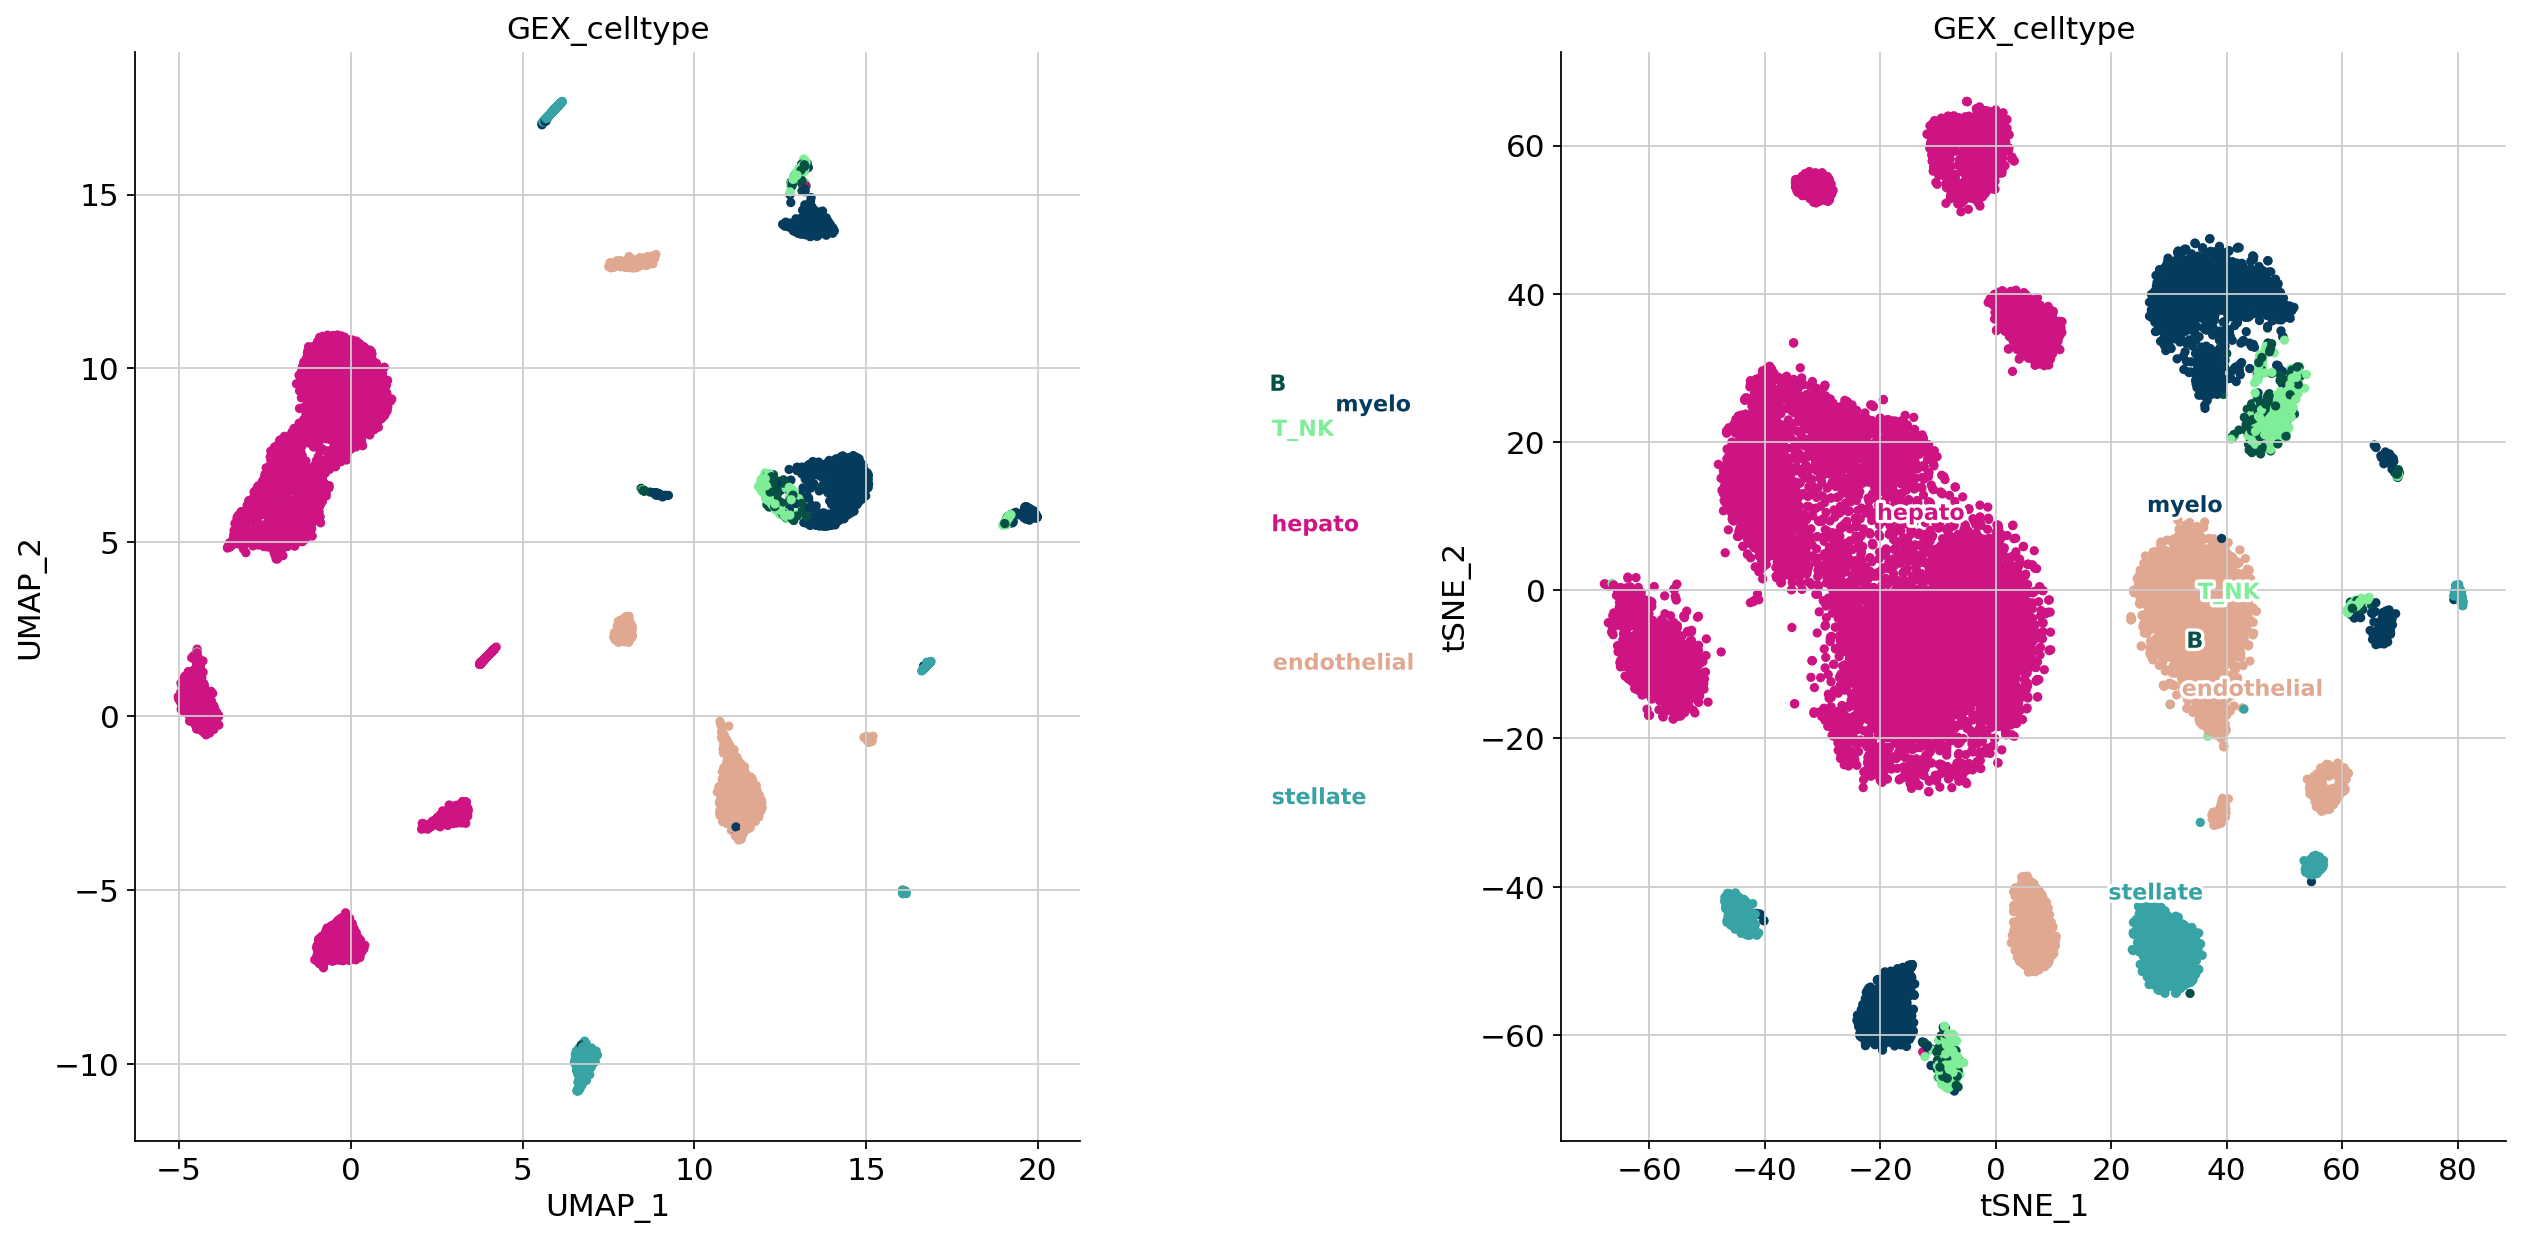

In [ ]:
from scenicplus.dimensionality_reduction import plot_metadata_given_ax
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#specify color_dictionary

color_dict = {
    'B': "#065143",
    #'B_cells_2': "#70B77E",
    'endothelial': "#E0A890",
    #'CD8_T_cells': "#F56476",
    'hepato': "#CE1483",
    'myelo': "#053C5E" ,
    'stellate': "#38A3A5",
    'T_NK': "#80ED99"
}

fig, axs = plt.subplots(ncols=2, figsize = (16, 8))
plot_metadata_given_ax(
    scplus_obj=scplus_obj,
    ax = axs[0],
    reduction_name = 'eRegulons_UMAP',
    variable = 'GEX_celltype', #note the GEX_ prefix, this metadata originated from the gene expression metadata (on which we did the cell type annotation before)
    color_dictionary={'GEX_celltype': color_dict}
)
plot_metadata_given_ax(
    scplus_obj=scplus_obj,
    ax = axs[1],
    reduction_name = 'eRegulons_tSNE',
    variable = 'GEX_celltype', #note the GEX_ prefix, this metadata originated from the gene expression metadata (on which we did the cell type annotation before)
    color_dictionary={'GEX_celltype': color_dict}
)
fig.tight_layout()
sns.despine(ax = axs[0]) #remove top and right edge of axis border
sns.despine(ax = axs[1]) #remove top and right edge of axis border
plt.show()

### plot the activity / expression of an eRegulon on the dimensionality reduction

Nex we visualize the gene expression and target gene and region activity of some eRegulons on the tSNE.

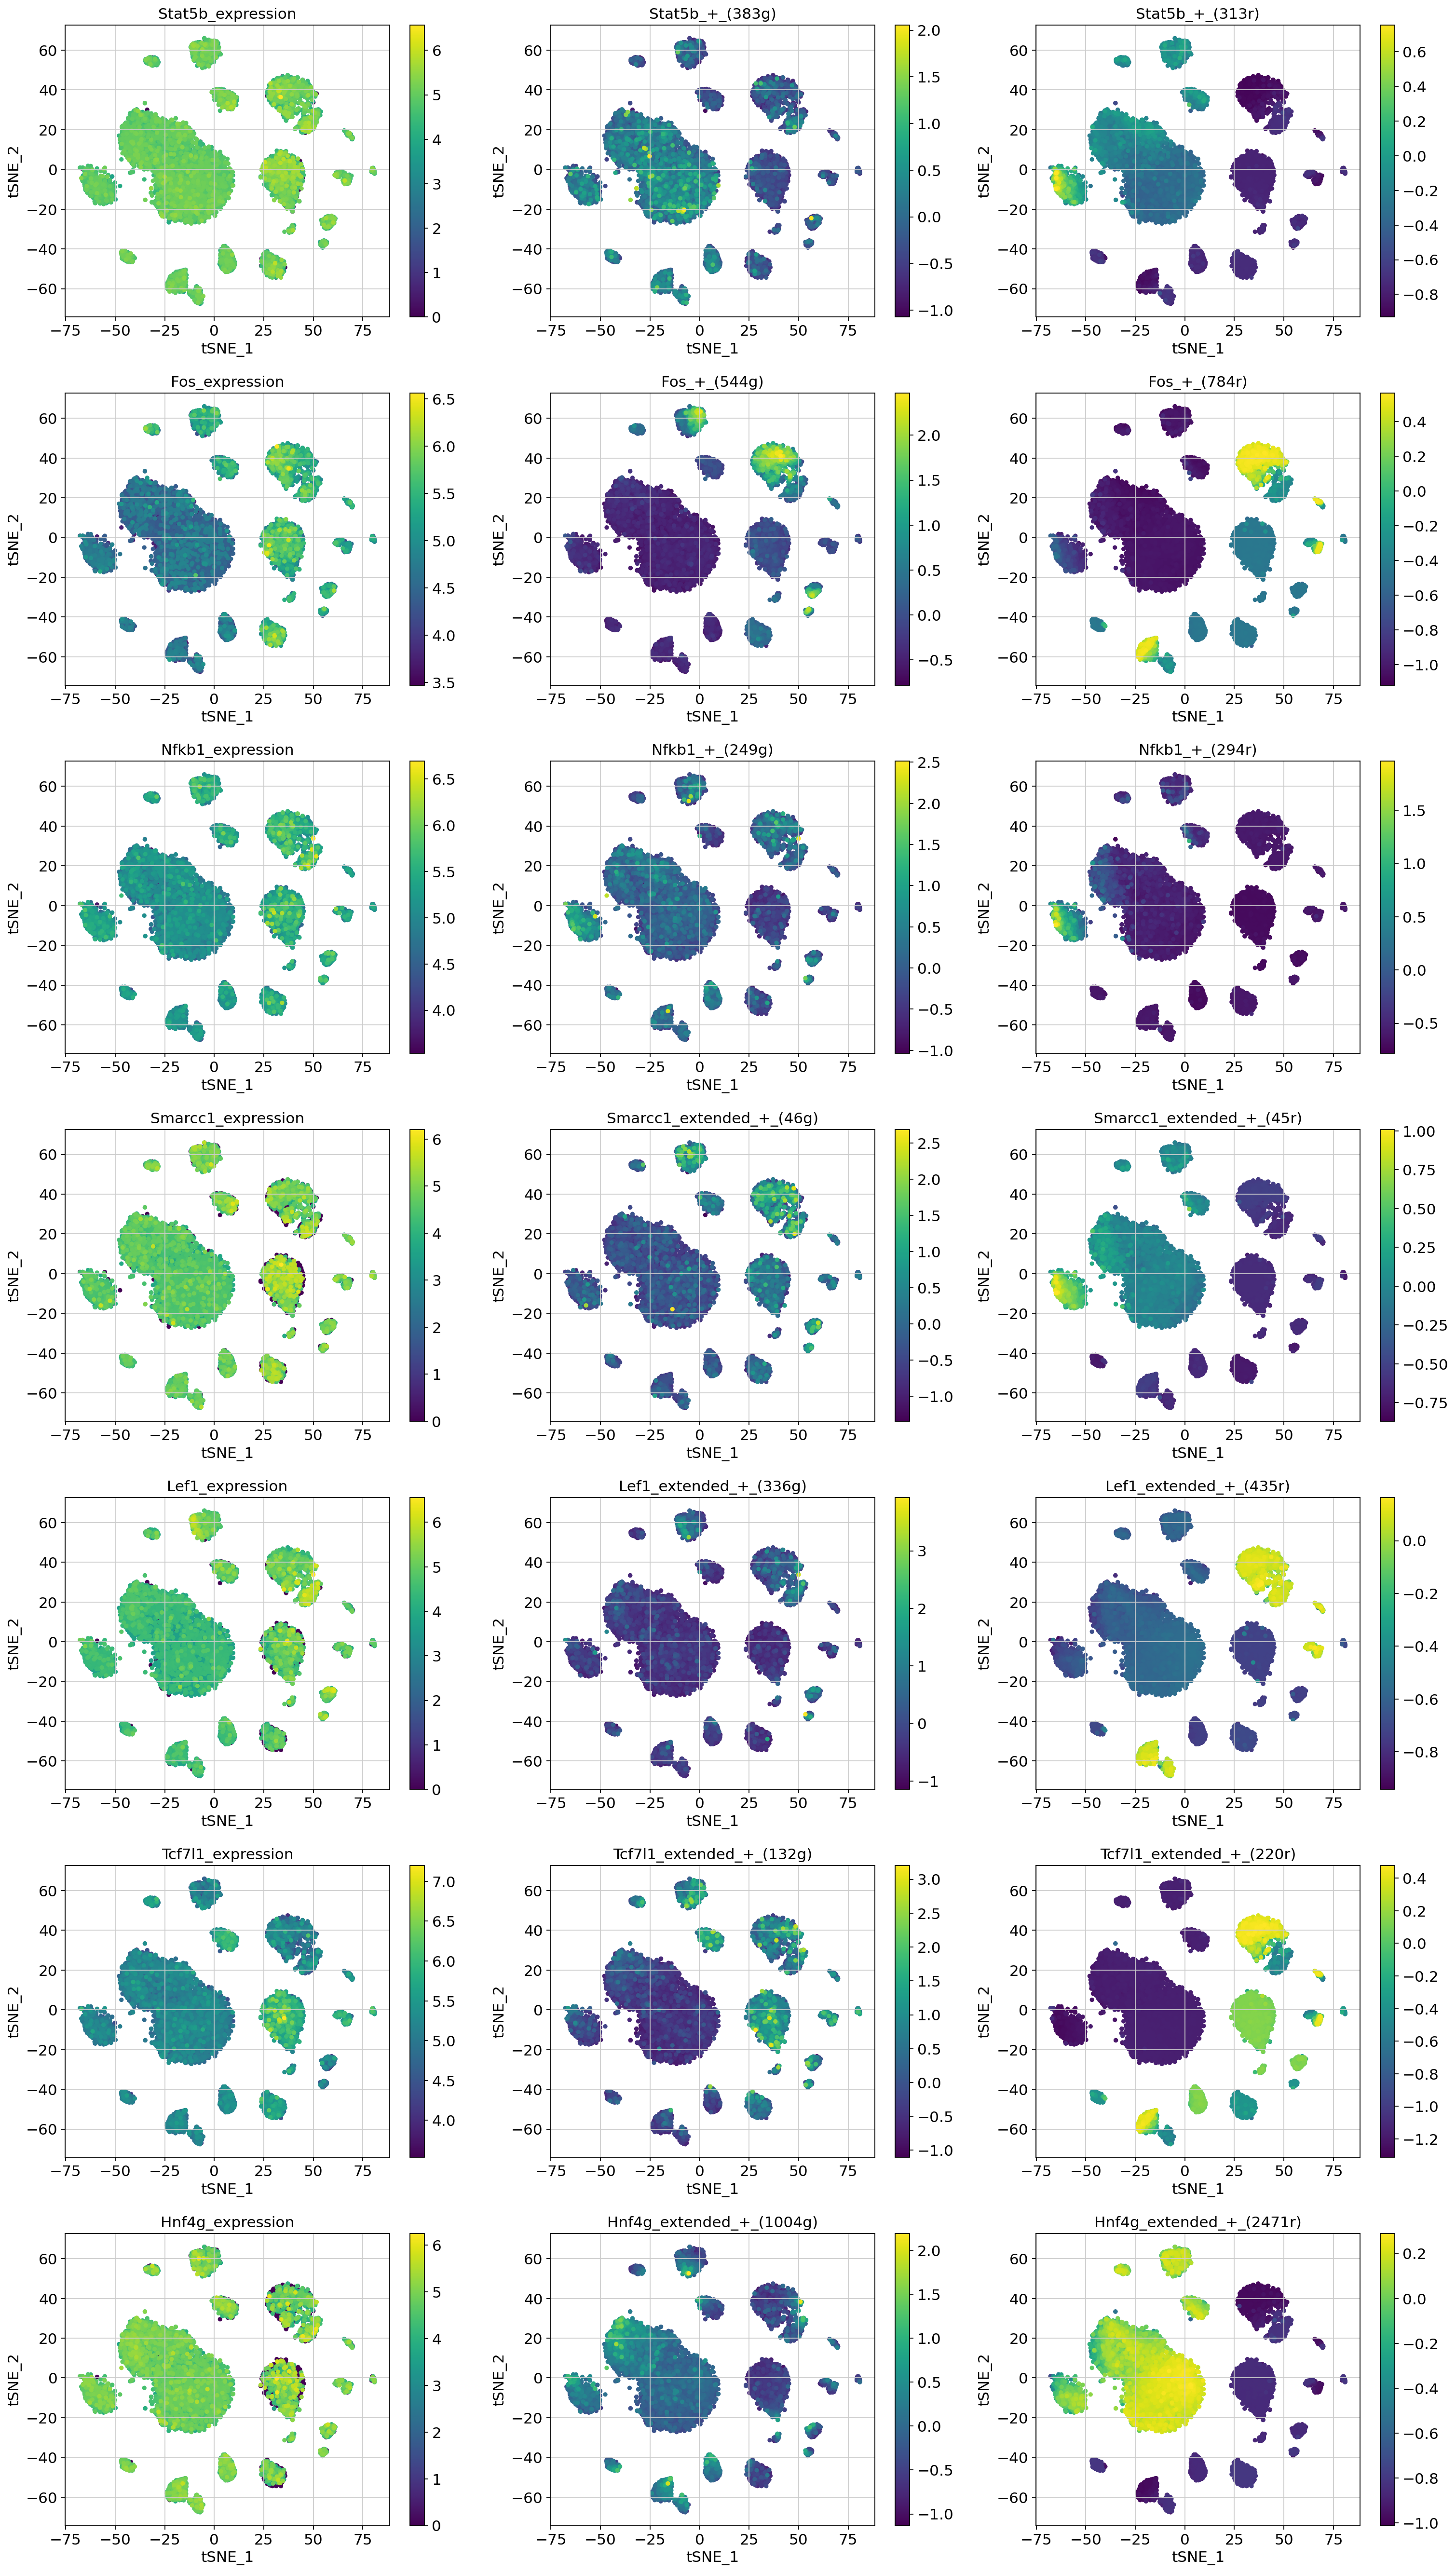

In [45]:
from scenicplus.dimensionality_reduction import plot_eRegulon
plot_eRegulon(
    scplus_obj = scplus_obj,
    reduction_name = 'eRegulons_tSNE',
    selected_regulons = ['Stat5b_+', 'Fos_+', 'Nfkb1_+', 'Smarcc1_extended_+','Lef1_extended_+','Tcf7l1_extended_+','Hnf4g_extended_+'],
    scale = True,
    auc_key = 'eRegulon_AUC_filtered')

We can also plot only the activity of an eRegulon

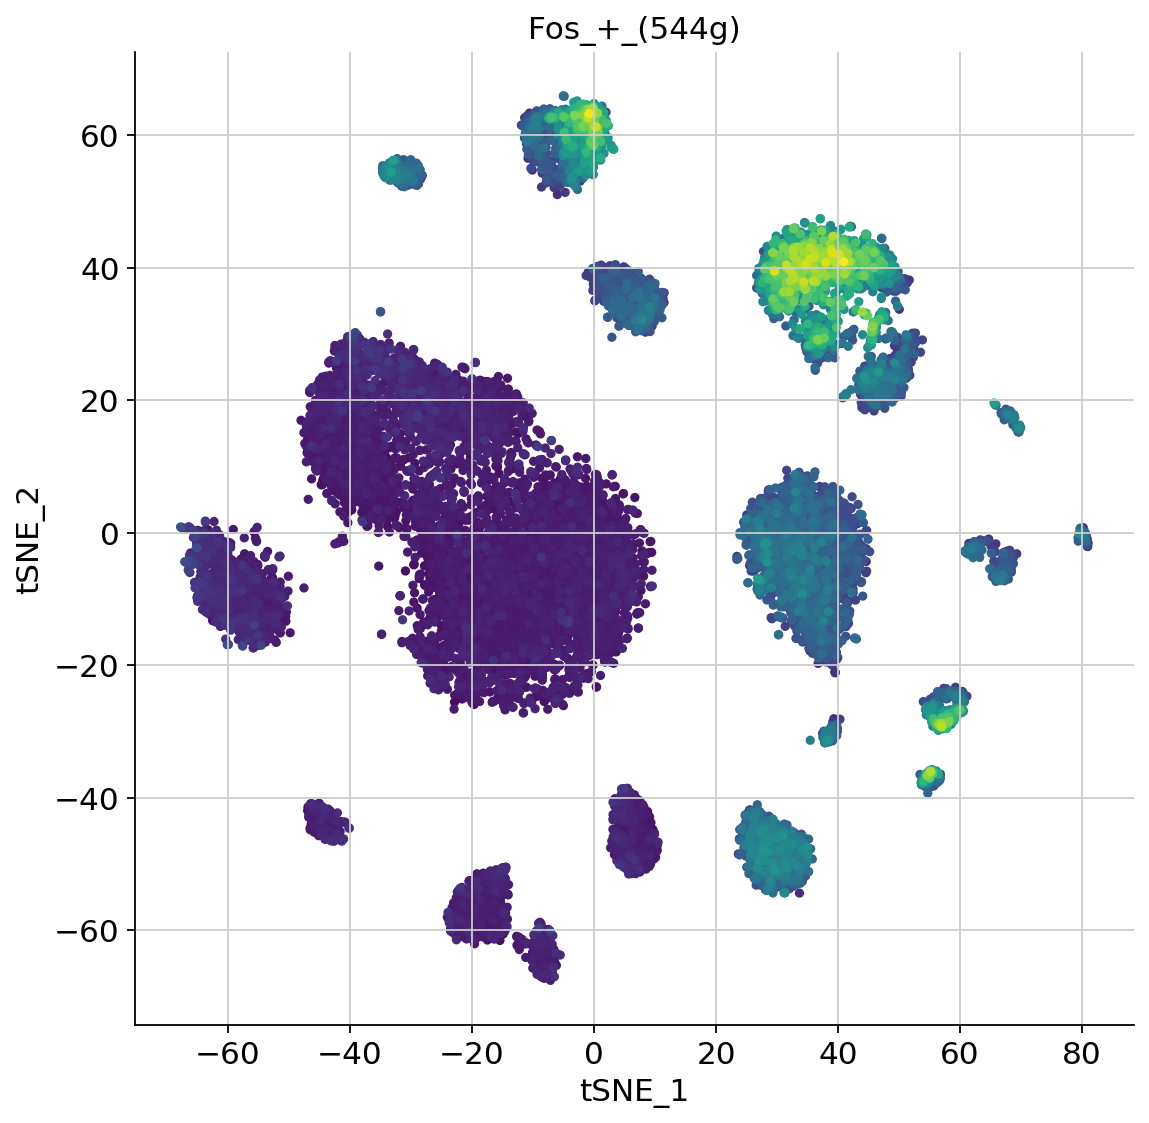

In [46]:
from scenicplus.dimensionality_reduction import plot_AUC_given_ax

fig, ax = plt.subplots(figsize = (8,8))
plot_AUC_given_ax(
    scplus_obj = scplus_obj,
    reduction_name = 'eRegulons_tSNE',
    feature = 'Fos_+_(544g)',
    ax = ax,
    auc_key = 'eRegulon_AUC_filtered',
    signature_key = 'Gene_based')
sns.despine(ax = ax)
plt.show()

### dotplot-heatmap

For eRegulons it is often usefull to visualize both information on the TF/target genes expression and region accessibility at the same time.

A dotplot-heatmap is a useful way to visualize this. Here the color of the heatmap can be used to visualize one aspect of the eRegulon (for example TF expression) and the size of the dot can be used to visualize another aspect (for example the enrichment (AUC value) of eRegulon target regions).

Before we plot the the dotplot-heatmap let's first select some high quality eRegulons to limit the amount of space we need for the plot. One metric which can be used for selecting eRegulons is the correlation between TF expression and target region enrichment scores (AUC values). Let's (re)calculate this value based on the simplified eRegulons

We first generate pseudobulk gene expression and region accessibility data, per celltype, to limit the amount of noise for the correlation calculation.

In [9]:
from scenicplus.cistromes import TF_cistrome_correlation, generate_pseudobulks

generate_pseudobulks(
        scplus_obj = scplus_obj,
        variable = 'GEX_celltype',
        auc_key = 'eRegulon_AUC_filtered',
        signature_key = 'Gene_based')
generate_pseudobulks(
        scplus_obj = scplus_obj,
        variable = 'GEX_celltype',
        auc_key = 'eRegulon_AUC_filtered',
        signature_key = 'Region_based')

TF_cistrome_correlation(
            scplus_obj,
            use_pseudobulk = True,
            variable = 'GEX_celltype',
            auc_key = 'eRegulon_AUC_filtered',
            signature_key = 'Gene_based',
            out_key = 'filtered_gene_based')
TF_cistrome_correlation(
            scplus_obj,
            use_pseudobulk = True,
            variable = 'GEX_celltype',
            auc_key = 'eRegulon_AUC_filtered',
            signature_key = 'Region_based',
            out_key = 'filtered_region_based')

In [11]:
scplus_obj.uns['TF_cistrome_correlation']

{'GEX_celltype_eGRN_gene_based': Empty DataFrame
 Columns: [TF, Cistrome, Rho, P-value, Adjusted_p-value]
 Index: [],
 'GEX_celltype_eGRN_region_based': Empty DataFrame
 Columns: [TF, Cistrome, Rho, P-value, Adjusted_p-value]
 Index: [],
 'filtered_gene_based':         TF                 Cistrome       Rho        P-value  Adjusted_p-value
 0    Creb5   Creb5_extended_-_(51g) -0.400726   1.501427e-24      2.469090e-24
 0     Nfib            Nfib_+_(555g)  0.881766  2.587248e-197     1.159410e-195
 0   Zfp398  Zfp398_extended_+_(38g) -0.092015   2.419662e-02      2.660886e-02
 0      Nf1    Nf1_extended_+_(442g)  0.542172   3.794700e-47      8.195180e-47
 0     Bnc2   Bnc2_extended_+_(203g)  0.450553   2.473034e-31      4.432913e-31
 ..     ...                      ...       ...            ...               ...
 0     Elf5            Elf5_+_(412g)  0.794164  1.823136e-131     1.675883e-130
 0    Nr4a2            Nr4a2_+_(70g)  0.045728   2.634198e-01      2.765329e-01
 0    Nr4a1  Nr4a1_

Let's visualize these correlations in a scatter plot and select eRegulons for which the correlaiton coefficient is above 0.70 or below -0.75

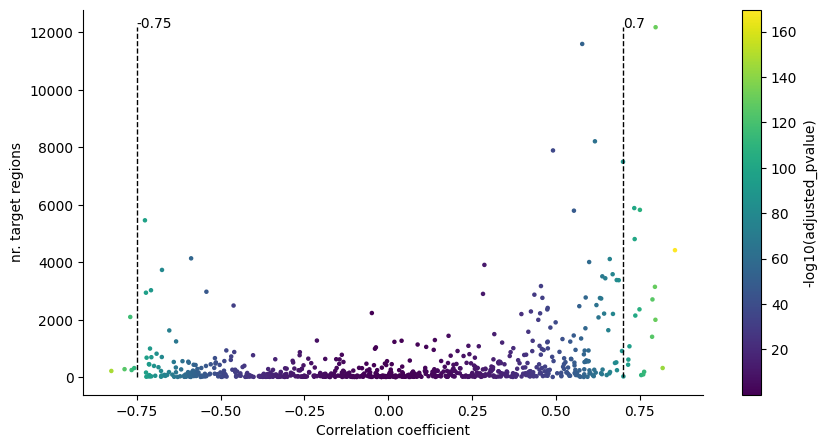

In [13]:
import matplotlib.pyplot as plt
import numpy as np
n_targets = [int(x.split('(')[1].replace('r)', '')) for x in scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Cistrome']]
rho = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'].to_list()
adj_pval = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Adjusted_p-value'].to_list()

thresholds = {
        'rho': [-0.75, 0.70],
        'n_targets': 0
}
import seaborn as sns
fig, ax = plt.subplots(figsize = (10, 5))
sc = ax.scatter(rho, n_targets, c = -np.log10(adj_pval), s = 5)
ax.set_xlabel('Correlation coefficient')
ax.set_ylabel('nr. target regions')
#ax.hlines(y = thresholds['n_targets'], xmin = min(rho), xmax = max(rho), color = 'black', ls = 'dashed', lw = 1)
ax.vlines(x = thresholds['rho'], ymin = 0, ymax = max(n_targets), color = 'black', ls = 'dashed', lw = 1)
ax.text(x = thresholds['rho'][0], y = max(n_targets), s = str(thresholds['rho'][0]))
ax.text(x = thresholds['rho'][1], y = max(n_targets), s = str(thresholds['rho'][1]))
sns.despine(ax = ax)
fig.colorbar(sc, label = '-log10(adjusted_pvalue)', ax = ax)
plt.show()

In [14]:
selected_cistromes = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based'].loc[
        np.logical_or(
                scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'] > thresholds['rho'][1],
                scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'] < thresholds['rho'][0]
        )]['Cistrome'].to_list()
selected_eRegulons = [x.split('_(')[0] for x in selected_cistromes]
selected_eRegulons_gene_sig = [
        x for x in scplus_obj.uns['eRegulon_signatures_filtered']['Gene_based'].keys()
        if x.split('_(')[0] in selected_eRegulons]
selected_eRegulons_region_sig = [
        x for x in scplus_obj.uns['eRegulon_signatures_filtered']['Region_based'].keys()
        if x.split('_(')[0] in selected_eRegulons]
#save the results in the scenicplus object
scplus_obj.uns['selected_eRegulon'] = {'Gene_based': selected_eRegulons_gene_sig, 'Region_based': selected_eRegulons_region_sig}
print(f'selected: {len(selected_eRegulons_gene_sig)} eRegulons')

selected: 25 eRegulons


Let's save these changes we have made to the scenicplus_obj

In [16]:
dill.dump(scplus_obj, open(os.path.join(work_dir, 'scenicplus/scplus_obj.pkl'), 'wb'), protocol=-1)

Let's plot the heatmap-dotplot

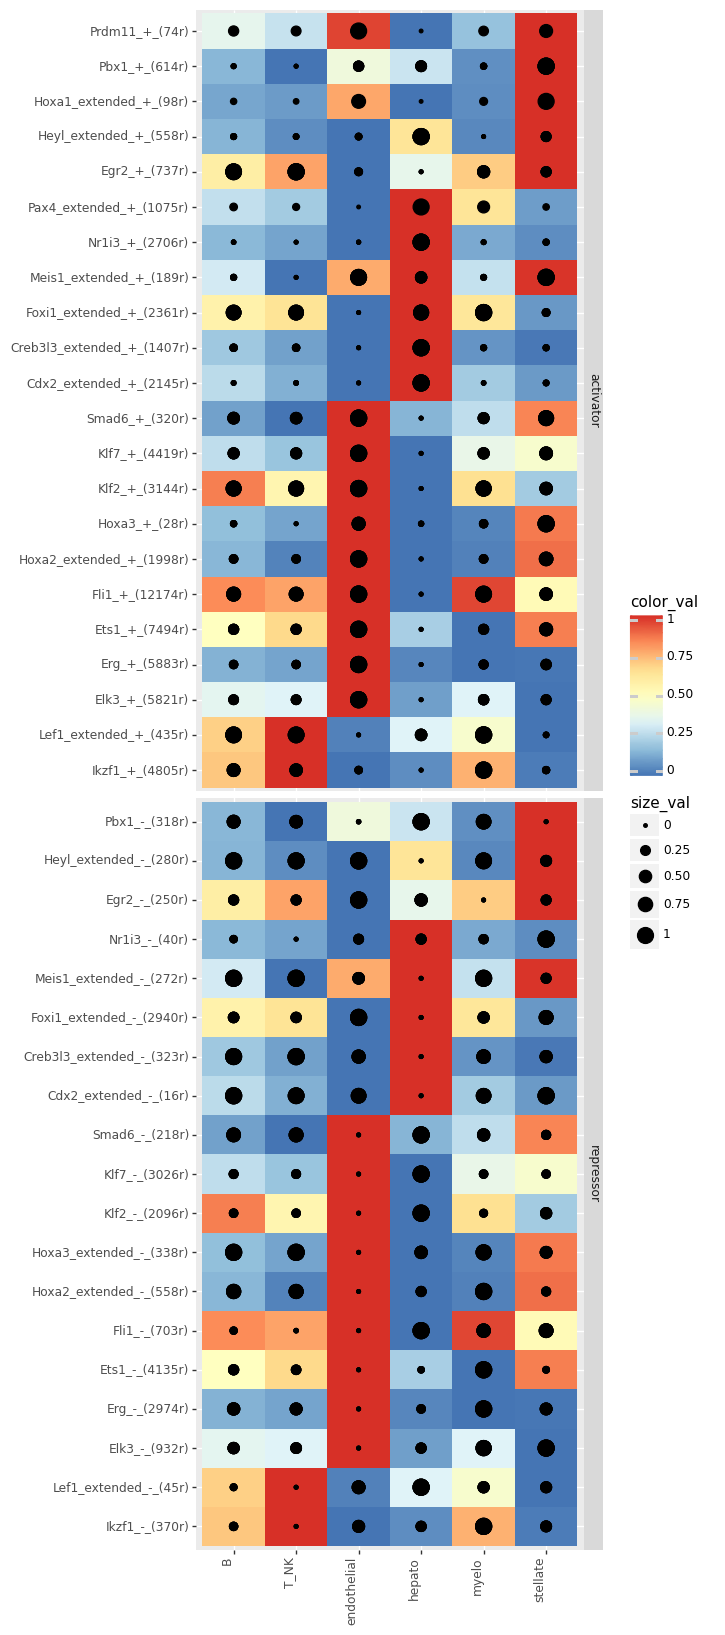

In [ ]:
from scenicplus.plotting.dotplot import heatmap_dotplot
heatmap_dotplot(
        scplus_obj = scplus_obj,
        size_matrix = scplus_obj.uns['eRegulon_AUC_filtered']['Region_based'], #specify what to plot as dot sizes, target region enrichment in this case
        color_matrix = scplus_obj.to_df('EXP'), #specify  what to plot as colors, TF expression in this case
        scale_size_matrix = True,
        scale_color_matrix = True,
        group_variable = 'GEX_celltype',
        subset_eRegulons = scplus_obj.uns['selected_eRegulon']['Gene_based'],
        index_order = ['B', 'T_NK', 'endothelial', 'hepato', 'myelo', 'stellate'],
        figsize = (5, 20),
        orientation = 'vertical')